In [212]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from keras.models import *
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold,cross_val_score
from sklearn.ensemble import StackingRegressor , BaggingRegressor

In [213]:
# Importation des jeux de données
train_df = pd.read_csv("certificatbigdata/train.csv",delimiter=",")
test_df = pd.read_csv("certificatbigdata/test.csv",delimiter=",")
store_df = pd.read_csv("certificatbigdata/store_metadata.csv",delimiter=",")

C:\Users\omabe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# DATA CLEANING

In [214]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813767 non-null  int64 
 1   date            813767 non-null  object
 2   customers       813767 non-null  int64 
 3   open            813767 non-null  int64 
 4   promo           813767 non-null  int64 
 5   state_holliday  813767 non-null  object
 6   school_holiday  813767 non-null  int64 
 7   y               813767 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 49.7+ MB


In [215]:
# On remarque que les données d'entrainement ne contiennent pas de valeurs NaN
train_df.isna().sum()

id                0
date              0
customers         0
open              0
promo             0
state_holliday    0
school_holiday    0
y                 0
dtype: int64

In [216]:
# Supprimer les données dupliquées
train_df = train_df.drop_duplicates()

In [217]:
print(f"unique open values :{train_df['open'].unique()}")
print(f"unique promo values :{train_df['promo'].unique()}")
print(f"unique state_holliday values :{train_df['state_holliday'].unique()}")
print(f"unique school_holiday values :{train_df['school_holiday'].unique()}")

unique open values :[0 1]
unique promo values :[0 1]
unique state_holliday values :['a' '0' 'b' 'c' 0]
unique school_holiday values :[1 0]


### state_holliday

In [218]:
# Observer les valeurs possibles de state_holliday
train_df['state_holliday'].value_counts()

0    761641
0     27335
a     16201
b      5322
c      3268
Name: state_holliday, dtype: int64

In [219]:
# Puisque state_holiday est binaire, on considère '0' , 0 => 0 et 'a','b','c' => 1
train_df['state_holliday'] = train_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)
test_df['state_holliday'] = test_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)

In [220]:
train_df['state_holliday'].value_counts()

0    788976
1     24791
Name: state_holliday, dtype: int64

### Open Var

In [221]:
# Voir si on dispose dans la base de données un magasin ouvert avec un volume des ventes positif
train_df[(train_df['open']==0) & (train_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [222]:
# Volume de ventes est toujours positif
train_df['y'].min()

0

In [223]:
test_df[(test_df['open']==0) & (test_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [224]:
test_df['y'].min()

0

In [225]:
# On déduit qu'on pourra nous en passer de l'input 'open' car quand ce n'est pas open la valeur y est nulle

#train_df = train_df.drop(columns=['open'])
#test_df = test_df.drop(columns=['open'])

In [226]:
# Vérifier si la variable Date ne prends pas des valeurs abérrantes

def chack_date(date):
  L = date.split('-')
  return len(L)==3 and len(L[0])==4 and len(L[1])==2 and len(L[2])==2
train_df['date'].apply(chack_date).value_counts()

True    813767
Name: date, dtype: int64

In [227]:
import seaborn as sns

<AxesSubplot:>

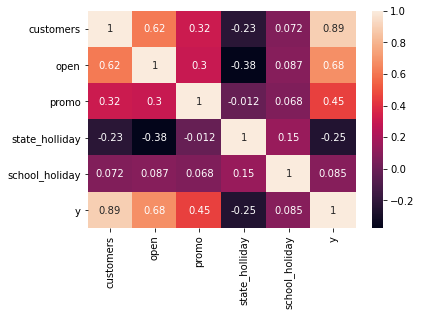

In [228]:
# Corrélation entre la variables; on remarque que le nombre de clients a une grande influence sur la nombre de ventes

sns.heatmap(train_df.drop(columns=['id']).corr(), annot=True)

In [229]:
# On remarque aussi qu'il y a une corrélation linéaire entre 'customers' et 'y'

#pd.plotting.scatter_matrix(train_df.drop(columns=['id','date']).sample(50000), alpha=0.2, figsize=(15,15))

## Store 

In [230]:
# Les valeurs possibles de 'store_type'

store_df['store_type'].value_counts()

a    602
d    348
c    148
b     17
Name: store_type, dtype: int64

In [231]:
# Les valeurs possibles de 'assortment'

store_df['assortment'].value_counts()

a    593
c    513
b      9
Name: assortment, dtype: int64

In [232]:
# Les valeurs possibles de 'promo_interval'

store_df['promo_interval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: promo_interval, dtype: int64

In [233]:
train_df['promo'].value_counts()

0    503121
1    310646
Name: promo, dtype: int64

## Features

In [234]:
# Rajouter la variable y/customers

train_df['SalesPerCustomers'] = train_df['y'] / train_df['customers']

avg_store = train_df.groupby('id')[['y', 'customers', 'SalesPerCustomers']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store_df = pd.merge(avg_store.reset_index(), store_df, on='id')
store_df.head()

,id,Avgy,Avgcustomers,AvgSalesPerCustomers,store_type,assortment,promo_interval
0,1,3950.539370,467.883202,8.397500,c,a,NaN
1,2,4117.196078,485.605229,8.408104,a,a,"Jan,Apr,Jul,Oct"
2,3,5850.149194,630.470430,9.138877,a,a,"Jan,Apr,Jul,Oct"
3,4,8028.679245,1102.529650,7.243965,c,c,NaN
4,5,3873.781291,445.283267,8.609952,a,a,NaN


In [235]:
# Rajout de la variable dayofweek et dayofyear
train_df['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek
test_df['day_of_week'] = pd.to_datetime(test_df['date']).dt.dayofweek

train_df['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear
test_df['day_of_year'] = pd.to_datetime(test_df['date']).dt.dayofyear

train_df['week_of_year'] = pd.to_datetime(train_df['date']).dt.weekofyear
test_df['week_of_year'] = pd.to_datetime(test_df['date']).dt.weekofyear

# okay = train_df.groupby(['id','day_of_week'])['y'].agg(['mean']).copy()
# train_df = pd.merge(left = train_df , right = okay.reset_index(), on=['id','day_of_week'], how ='left')
# test_df = pd.merge(left = test_df, right = okay.reset_index(),on=['id','day_of_week'], how ='left')

train_df.head()

<ipython-input-235-df9ea89b12cf>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_df['week_of_year'] = pd.to_datetime(train_df['date']).dt.weekofyear
<ipython-input-235-df9ea89b12cf>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_df['week_of_year'] = pd.to_datetime(test_df['date']).dt.weekofyear


,id,date,customers,open,promo,state_holliday,school_holiday,y,SalesPerCustomers,day_of_week,day_of_year,week_of_year
0,1042,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
1,128,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
2,420,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
3,225,2013-01-01,0,0,0,1,1,0,NaN,1,1,1
4,144,2013-01-01,0,0,0,1,1,0,NaN,1,1,1


In [236]:
# Rajout de y(dayofyear-7)

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
df = train_df.groupby('id').apply(lambda x: x.set_index('date').resample('1D').first())
df1 = df.groupby(level=0)['y'].apply(lambda x: x.shift().rolling(min_periods=1,window=7).mean()).reset_index(name='Value_Average_Past_7_days')
display(df1.head())
train_df = pd.merge(left = train_df , right = df1, on=['id','date'], how ='left')
test_df = pd.merge(left = test_df , right = df1, on=['id','date'], how ='left')

,id,date,Value_Average_Past_7_days
0,1,2013-01-02,NaN
1,1,2013-01-03,5530.0
2,1,2013-01-04,4928.5
3,1,2013-01-05,4781.0
4,1,2013-01-06,4835.0


In [237]:
train_df['Value_Average_Past_7_days'].isna().sum()

1307

In [238]:
#Ratio = y/customers byday_of_week
train_group = train_df.groupby(['id','day_of_week'])

ratio_df = pd.DataFrame({'ratio_by_day_of_week':train_group['y'].sum()/train_group['customers'].sum()})
customers_perday = pd.DataFrame({'CustomersPerDay':train_group['customers'].sum()})

train_df= pd.merge(left = train_df, right = ratio_df ,on=['id','day_of_week'], how ='left')
test_df = pd.merge(left = test_df, right = ratio_df,on=['id','day_of_week'], how ='left')

train_df= pd.merge(left = train_df, right = customers_perday ,on=['id','day_of_week'], how ='left')
test_df = pd.merge(left = test_df, right = customers_perday,on=['id','day_of_week'], how ='left')

#Rajout de app_y = ratio_by_dayofweek * customers
train_df['app_p'] = train_df['customers']*train_df['ratio_by_day_of_week']
test_df['app_p'] = test_df['customers']*test_df['ratio_by_day_of_week']

test_df

,id,date,customers,open,promo,state_holliday,school_holiday,y,day_of_week,day_of_year,week_of_year,Value_Average_Past_7_days,ratio_by_day_of_week,CustomersPerDay,app_p
0,1105,2013-01-01,0,0,0,1,1,0,1,1,1,NaN,8.886458,53302,0.000000
1,306,2013-01-01,0,0,0,1,1,0,1,1,1,NaN,9.355798,42794,0.000000
2,1115,2013-01-01,0,0,0,1,1,0,1,1,1,NaN,14.573775,43355,0.000000
3,506,2013-01-01,0,0,0,1,1,0,1,1,1,NaN,9.022218,85560,0.000000
4,877,2013-01-01,0,0,0,1,1,0,1,1,1,NaN,7.372790,105188,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203437,728,2015-07-31,542,1,1,0,1,0,4,212,31,NaN,11.468789,52610,6216.083748
203438,323,2015-07-31,716,1,1,0,1,0,4,212,31,NaN,11.870420,63891,8499.220673
203439,912,2015-07-31,806,1,1,0,1,0,4,212,31,NaN,7.555701,81229,6089.894644
203440,276,2015-07-31,575,1,1,0,1,0,4,212,31,NaN,7.808782,61537,4490.049482


In [239]:
# Remove points with 0 Sales
# Set Open = 0 when Sales = 0 OR Customers = 0
# train_df.loc[ (train_df['customers']==0) | (train_df['y']==0) , 'open' ] = 0
# train_df = train_df[train_df['open'] == 1]

# Building features

In [240]:
pd.set_option('display.max_columns', None)

In [241]:
def build_features(train = train_df, store = store_df):
    # Convert string types into integers
    store['store_type'] = store['store_type'].astype('category').cat.codes
    store['assortment'] = store['assortment'].astype('category').cat.codes
    store['promo_interval'] = store['promo_interval'].astype('category').cat.codes
    train["state_holliday"] = train["state_holliday"].astype('category').cat.codes
    
    merged = pd.merge(train, store, on='id', how='left')
    
    merged['Year'] = pd.to_datetime(merged['date']).dt.year
    merged['Month'] = pd.to_datetime(merged['date']).dt.month
    merged['Day'] = pd.to_datetime(merged['date']).dt.day
    merged['Week'] = pd.to_datetime(merged['date']).dt.week
    
#     merged.loc[(merged['Month'].isin([1,4,7,10])) & (merged['promo_interval'] == 0),'PromoInter'] = 1
#     merged.loc[(merged['Month'].isin([2,5,8,11])) & (merged['promo_interval'] == 1) ,'PromoInter'] = 1
#     merged.loc[(merged['Month'].isin([3,6,9,12])) & (merged['promo_interval'] == 2) ,'PromoInter'] = 1
#     merged.loc[merged['promo_interval'] == -1 ,'PromoInter'] = -1
    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)
    
    #merged = merged[merged['Month'] != 12] #Supprimer les valeurs du mois de Décembre

    return merged

med_store = train_df.groupby('id')[['y', 'customers', 'SalesPerCustomers']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store_df = pd.merge(med_store.reset_index(), store_df, on='id')
features = build_features(train_df, store_df)
features

<ipython-input-241-7fb8fb43d66a>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


,id,date,customers,open,promo,state_holliday,school_holiday,y,SalesPerCustomers,day_of_week,day_of_year,week_of_year,Value_Average_Past_7_days,ratio_by_day_of_week,CustomersPerDay,app_p,Medy,Medcustomers,MedSalesPerCustomers,Avgy,Avgcustomers,AvgSalesPerCustomers,store_type,assortment,promo_interval,Year,Month,Day,Week
0,1042,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,0.00,7.412280,62460,0.000000,3627.0,512.0,7.346963,3363.957839,446.072464,7.443203,0,0,0,2013,1,1,1
1,128,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,0.00,12.703947,64708,0.000000,6671.5,556.0,12.276435,6176.957143,492.961039,12.373707,3,2,1,2013,1,1,1
2,420,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,0.00,11.001093,31100,0.000000,4156.5,382.0,11.209468,3769.974832,334.003356,11.193422,3,2,1,2013,1,1,1
3,225,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,0.00,9.484903,57593,0.000000,4565.0,519.0,9.164230,4367.282993,467.165986,9.247951,3,0,-1,2013,1,1,1
4,144,2013-01-01,0,0,0,1,1,0,0.000000,1,1,1,0.00,10.635794,55098,0.000000,7030.0,691.0,10.433333,6343.254576,599.552413,10.508401,0,2,-1,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343,13.659357,4,212,31,5423.60,11.625640,51739,7951.937919,5527.0,501.0,11.425388,5095.916777,439.859974,11.482440,0,2,-1,2015,7,31,31
813763,796,2015-07-31,769,1,1,0,1,8913,11.590377,4,212,31,5823.40,10.584014,66834,8139.106862,6426.0,645.0,10.737490,5960.280702,548.217274,10.767563,0,2,-1,2015,7,31,31
813764,230,2015-07-31,1091,1,1,0,1,10988,10.071494,4,212,31,4674.25,8.097225,101774,8834.072720,6948.0,896.0,7.904656,6305.500666,783.585885,7.973675,3,2,-1,2015,7,31,31
813765,387,2015-07-31,1402,1,1,0,1,14533,10.365906,4,212,31,9584.00,7.753565,118376,10870.498006,7784.0,1094.0,7.587732,7561.992011,963.762983,7.727806,2,0,2,2015,7,31,31


In [242]:
#Remove outliers

# def reject_outliers(df,col_name, m=2.6):
#     return df[ (df[col_name] - df[col_name].mean()).abs() < m * df[col_name].std()]

# features = pd.concat([reject_outliers(df,'SalesPerCustomers') for ID,df in features.groupby(['id'])])
# features = features.sort_index()

# features

In [243]:
X = [
    'id', 
    'customers',
    'promo',
    #'promo_interval',
    #'PromoInter',
    
    'school_holiday',
    'state_holliday',
    'store_type',
    'assortment',

    'Avgy',
    'Avgcustomers',
    'AvgSalesPerCustomers',
    
    'Medy',
    'Medcustomers',
    'MedSalesPerCustomers',

    'day_of_week',
    'day_of_year',
    'week_of_year',
    
    'Week',
    'Day',
    'Month',
    'Year',
    
    'ratio_by_day_of_week',
    'app_p',
    'CustomersPerDay',
    
    #'Value_Average_Past_7_days'
]

X_train, X_valid, y_train, y_valid = train_test_split(
    features[X], features['y'], test_size=0.15, random_state=42)

X1 , y1 = features[X].copy(), features['y'].copy()

In [244]:
#Scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)

In [245]:
# Print input/target format 
print(f'Input shape  : {X1.shape}')
print(f'Target shape : {y1.shape}')
display(X1)

Input shape  : (813767, 23)
Target shape : (813767,)


,id,customers,promo,school_holiday,state_holliday,store_type,assortment,Avgy,Avgcustomers,AvgSalesPerCustomers,Medy,Medcustomers,MedSalesPerCustomers,day_of_week,day_of_year,week_of_year,Week,Day,Month,Year,ratio_by_day_of_week,app_p,CustomersPerDay
0,1042,0,0,1,1,0,0,3363.957839,446.072464,7.443203,3627.0,512.0,7.346963,1,1,1,1,1,1,2013,7.412280,0.000000,62460
1,128,0,0,1,1,3,2,6176.957143,492.961039,12.373707,6671.5,556.0,12.276435,1,1,1,1,1,1,2013,12.703947,0.000000,64708
2,420,0,0,1,1,3,2,3769.974832,334.003356,11.193422,4156.5,382.0,11.209468,1,1,1,1,1,1,2013,11.001093,0.000000,31100
3,225,0,0,1,1,3,0,4367.282993,467.165986,9.247951,4565.0,519.0,9.164230,1,1,1,1,1,1,2013,9.484903,0.000000,57593
4,144,0,0,1,1,0,2,6343.254576,599.552413,10.508401,7030.0,691.0,10.433333,1,1,1,1,1,1,2013,10.635794,0.000000,55098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,684,1,1,0,0,2,5095.916777,439.859974,11.482440,5527.0,501.0,11.425388,4,212,31,31,31,7,2015,11.625640,7951.937919,51739
813763,796,769,1,1,0,0,2,5960.280702,548.217274,10.767563,6426.0,645.0,10.737490,4,212,31,31,31,7,2015,10.584014,8139.106862,66834
813764,230,1091,1,1,0,3,2,6305.500666,783.585885,7.973675,6948.0,896.0,7.904656,4,212,31,31,31,7,2015,8.097225,8834.072720,101774
813765,387,1402,1,1,0,2,0,7561.992011,963.762983,7.727806,7784.0,1094.0,7.587732,4,212,31,31,31,7,2015,7.753565,10870.498006,118376


In [246]:
# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
#print(f'Test size : {X_test.shape[0]}')

Train size : 691701
Validation size : 122066


In [247]:
# Vérifier si X1 et test_df_new ne contient au final que des valeurs numériques

X1.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
# test_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

id                      True
customers               True
promo                   True
school_holiday          True
state_holliday          True
store_type              True
assortment              True
Avgy                    True
Avgcustomers            True
AvgSalesPerCustomers    True
Medy                    True
Medcustomers            True
MedSalesPerCustomers    True
day_of_week             True
day_of_year             True
week_of_year            True
Week                    True
Day                     True
Month                   True
Year                    True
ratio_by_day_of_week    True
app_p                   True
CustomersPerDay         True
dtype: bool

## Remove Outliers

In [657]:
# #remove outliers
# train_nozero['ratio'] = train_nozero['y']/train_nozero['customers']
# def reject_outliers(df,col_name, m=1):
#     return df[ (df[col_name] - df[col_name].mean()).abs() < m * df[col_name].std()]

# train_nozero = pd.concat([reject_outliers(df,'ratio') for ID,df in train_nozero.groupby(['id'])])

In [ ]:
# train_nozero = train_nozero.sort_index()
# train_nozero = train_nozero.drop(columns=['ratio'])

# test_df_new

# Models

## XGBoost

In [ ]:
xgb = XGBRegressor(
    n_estimators = 140,
    eta = 0.1,
    max_depth = 17,
    min_child_weight = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.06,
    random_state = 1043)

In [ ]:
xgb.fit(X1, y1,eval_metric = 'mae')

In [ ]:
features = build_features(test_df, store_df)

test_preds = xgb.predict(features[X])

test_preds

In [ ]:
xgb.fit(X_train[X], y_train, 
                 eval_set = [(X_train[X], y_train), (X_valid[X], y_valid)],
                 eval_metric = 'mae',
                 early_stopping_rounds = 200
                )

In [ ]:
from sklearn import model_selection
def evaluate_model(model, X, y):
    cv = model_selection.KFold(n_splits=5)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, error_score='raise',verbose=1)
    return scores

In [ ]:
evaluate_model(xgb,X1,y1)

## Random Forest

In [ ]:
rdmForest = RandomForestRegressor(n_estimators=300, max_depth=17, n_jobs=-1, random_state=1043)

rdmForest.fit(X1,y1)

In [ ]:
features = build_features(test_df, store_df)

test_preds = rdmForest.predict(features[X])

test_preds

In [ ]:
mae(y1,model.predict(X1))

## Decision Tree Regressor

In [ ]:
desision_tree = DecisionTreeRegressor(splitter='random', max_depth=16, random_state=21)

desision_tree.fit(X1, y1)

In [ ]:
features = build_features(test_df, store_df)

test_preds = desision_tree.predict(features[X])

test_preds

## LightGBM

In [267]:
import lightgbm as lgb
base_lgb_model = lgb.LGBMRegressor(num_leaves=65,
                               n_estimators=4900, 
                               max_depth=15,  
                               min_child_weight=0.008,
                               learning_rate=0.12,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               reg_alpha=0.1,
                               reg_lambda=1,
                               verbose = 1
                                )



In [266]:
base_lgb_model.fit(X_train[X], y_train, 
                 eval_set = [(X_train[X], y_train), (X_valid[X], y_valid)],
                 eval_metric = 'mae',
                 early_stopping_rounds = 200
                )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3231
[LightGBM] [Info] Number of data points in the train set: 691701, number of used features: 23
[LightGBM] [Info] Start training from score 5775.228055
[1]	valid_0's l1: 2548.75	valid_0's l2: 1.15451e+07	valid_1's l1: 2543.62	valid_1's l2: 1.15125e+07
Training until validation scores don't improve for 200 rounds
[2]	valid_0's l1: 2249.79	valid_0's l2: 9.00196e+06	valid_1's l1: 2245.66	valid_1's l2: 8.97997e+06
[3]	valid_0's l1: 1987.52	valid_0's l2: 7.02988e+06	valid_1's l1: 1984.12	valid_1's l2: 7.01488e+06
[4]	valid_0's l1: 1757.6	valid_0's l2: 5.50131e+06	valid_1's l1: 1755.03	valid_1's l2: 5.49221e+06
[5]	valid_0's l1: 1555.93	valid_0's l2: 4.31625e+06	valid_1's l1: 1554.04	valid_1's l2: 4.31137e+06
[6]	valid_0's l1: 1379.28	valid_0's l2: 3.39698e+06	valid_1's l1: 1378.09	valid_1's l2: 3.

[86]	valid_0's l1: 230.998	valid_0's l2: 130955	valid_1's l1: 233.736	valid_1's l2: 140284
[87]	valid_0's l1: 230.905	valid_0's l2: 130793	valid_1's l1: 233.668	valid_1's l2: 140158
[88]	valid_0's l1: 230.764	valid_0's l2: 130555	valid_1's l1: 233.566	valid_1's l2: 140009
[89]	valid_0's l1: 230.621	valid_0's l2: 130325	valid_1's l1: 233.446	valid_1's l2: 139819
[90]	valid_0's l1: 230.558	valid_0's l2: 130181	valid_1's l1: 233.396	valid_1's l2: 139682
[91]	valid_0's l1: 230.492	valid_0's l2: 129982	valid_1's l1: 233.358	valid_1's l2: 139534
[92]	valid_0's l1: 230.375	valid_0's l2: 129799	valid_1's l1: 233.275	valid_1's l2: 139415
[93]	valid_0's l1: 230.237	valid_0's l2: 129669	valid_1's l1: 233.147	valid_1's l2: 139288
[94]	valid_0's l1: 230.153	valid_0's l2: 129442	valid_1's l1: 233.082	valid_1's l2: 139093
[95]	valid_0's l1: 230.097	valid_0's l2: 129283	valid_1's l1: 233.049	valid_1's l2: 139007
[96]	valid_0's l1: 229.937	valid_0's l2: 129057	valid_1's l1: 232.92	valid_1's l2: 138826


[175]	valid_0's l1: 223.893	valid_0's l2: 118781	valid_1's l1: 228.478	valid_1's l2: 131286
[176]	valid_0's l1: 223.862	valid_0's l2: 118711	valid_1's l1: 228.457	valid_1's l2: 131219
[177]	valid_0's l1: 223.824	valid_0's l2: 118668	valid_1's l1: 228.432	valid_1's l2: 131190
[178]	valid_0's l1: 223.782	valid_0's l2: 118578	valid_1's l1: 228.402	valid_1's l2: 131118
[179]	valid_0's l1: 223.764	valid_0's l2: 118522	valid_1's l1: 228.402	valid_1's l2: 131098
[180]	valid_0's l1: 223.706	valid_0's l2: 118458	valid_1's l1: 228.357	valid_1's l2: 131061
[181]	valid_0's l1: 223.631	valid_0's l2: 118348	valid_1's l1: 228.309	valid_1's l2: 130972
[182]	valid_0's l1: 223.574	valid_0's l2: 118271	valid_1's l1: 228.27	valid_1's l2: 130923
[183]	valid_0's l1: 223.492	valid_0's l2: 118163	valid_1's l1: 228.212	valid_1's l2: 130860
[184]	valid_0's l1: 223.455	valid_0's l2: 118083	valid_1's l1: 228.193	valid_1's l2: 130805
[185]	valid_0's l1: 223.416	valid_0's l2: 118019	valid_1's l1: 228.169	valid_1's 

[272]	valid_0's l1: 218.871	valid_0's l2: 111522	valid_1's l1: 225.07	valid_1's l2: 126499
[273]	valid_0's l1: 218.828	valid_0's l2: 111457	valid_1's l1: 225.039	valid_1's l2: 126466
[274]	valid_0's l1: 218.787	valid_0's l2: 111399	valid_1's l1: 225.025	valid_1's l2: 126452
[275]	valid_0's l1: 218.711	valid_0's l2: 111339	valid_1's l1: 224.962	valid_1's l2: 126409
[276]	valid_0's l1: 218.667	valid_0's l2: 111272	valid_1's l1: 224.942	valid_1's l2: 126375
[277]	valid_0's l1: 218.627	valid_0's l2: 111219	valid_1's l1: 224.915	valid_1's l2: 126337
[278]	valid_0's l1: 218.58	valid_0's l2: 111163	valid_1's l1: 224.892	valid_1's l2: 126311
[279]	valid_0's l1: 218.534	valid_0's l2: 111097	valid_1's l1: 224.867	valid_1's l2: 126300
[280]	valid_0's l1: 218.496	valid_0's l2: 111044	valid_1's l1: 224.851	valid_1's l2: 126272
[281]	valid_0's l1: 218.453	valid_0's l2: 110981	valid_1's l1: 224.827	valid_1's l2: 126226
[282]	valid_0's l1: 218.43	valid_0's l2: 110940	valid_1's l1: 224.81	valid_1's l2:

[363]	valid_0's l1: 215.619	valid_0's l2: 106892	valid_1's l1: 223.356	valid_1's l2: 123804
[364]	valid_0's l1: 215.563	valid_0's l2: 106830	valid_1's l1: 223.317	valid_1's l2: 123768
[365]	valid_0's l1: 215.445	valid_0's l2: 106734	valid_1's l1: 223.212	valid_1's l2: 123684
[366]	valid_0's l1: 215.416	valid_0's l2: 106698	valid_1's l1: 223.208	valid_1's l2: 123671
[367]	valid_0's l1: 215.391	valid_0's l2: 106657	valid_1's l1: 223.187	valid_1's l2: 123639
[368]	valid_0's l1: 215.362	valid_0's l2: 106586	valid_1's l1: 223.177	valid_1's l2: 123625
[369]	valid_0's l1: 215.348	valid_0's l2: 106559	valid_1's l1: 223.182	valid_1's l2: 123627
[370]	valid_0's l1: 215.325	valid_0's l2: 106537	valid_1's l1: 223.163	valid_1's l2: 123612
[371]	valid_0's l1: 215.283	valid_0's l2: 106492	valid_1's l1: 223.135	valid_1's l2: 123583
[372]	valid_0's l1: 215.264	valid_0's l2: 106458	valid_1's l1: 223.127	valid_1's l2: 123567
[373]	valid_0's l1: 215.235	valid_0's l2: 106412	valid_1's l1: 223.112	valid_1's

[454]	valid_0's l1: 212.458	valid_0's l2: 102914	valid_1's l1: 221.559	valid_1's l2: 121472
[455]	valid_0's l1: 212.439	valid_0's l2: 102891	valid_1's l1: 221.555	valid_1's l2: 121473
[456]	valid_0's l1: 212.417	valid_0's l2: 102869	valid_1's l1: 221.551	valid_1's l2: 121465
[457]	valid_0's l1: 212.385	valid_0's l2: 102823	valid_1's l1: 221.536	valid_1's l2: 121453
[458]	valid_0's l1: 212.347	valid_0's l2: 102799	valid_1's l1: 221.511	valid_1's l2: 121435
[459]	valid_0's l1: 212.314	valid_0's l2: 102769	valid_1's l1: 221.492	valid_1's l2: 121412
[460]	valid_0's l1: 212.27	valid_0's l2: 102721	valid_1's l1: 221.46	valid_1's l2: 121379
[461]	valid_0's l1: 212.235	valid_0's l2: 102677	valid_1's l1: 221.436	valid_1's l2: 121356
[462]	valid_0's l1: 212.206	valid_0's l2: 102622	valid_1's l1: 221.424	valid_1's l2: 121350
[463]	valid_0's l1: 212.152	valid_0's l2: 102567	valid_1's l1: 221.391	valid_1's l2: 121313
[464]	valid_0's l1: 212.135	valid_0's l2: 102541	valid_1's l1: 221.392	valid_1's l

[545]	valid_0's l1: 209.447	valid_0's l2: 99274.6	valid_1's l1: 219.782	valid_1's l2: 119505
[546]	valid_0's l1: 209.432	valid_0's l2: 99256.2	valid_1's l1: 219.782	valid_1's l2: 119499
[547]	valid_0's l1: 209.38	valid_0's l2: 99196.6	valid_1's l1: 219.758	valid_1's l2: 119478
[548]	valid_0's l1: 209.348	valid_0's l2: 99157.9	valid_1's l1: 219.746	valid_1's l2: 119466
[549]	valid_0's l1: 209.336	valid_0's l2: 99137.8	valid_1's l1: 219.739	valid_1's l2: 119448
[550]	valid_0's l1: 209.289	valid_0's l2: 99082.9	valid_1's l1: 219.71	valid_1's l2: 119405
[551]	valid_0's l1: 209.272	valid_0's l2: 99061.7	valid_1's l1: 219.701	valid_1's l2: 119399
[552]	valid_0's l1: 209.264	valid_0's l2: 99045.4	valid_1's l1: 219.703	valid_1's l2: 119413
[553]	valid_0's l1: 209.243	valid_0's l2: 99025.2	valid_1's l1: 219.685	valid_1's l2: 119401
[554]	valid_0's l1: 209.229	valid_0's l2: 99002.4	valid_1's l1: 219.683	valid_1's l2: 119388
[555]	valid_0's l1: 209.206	valid_0's l2: 98967	valid_1's l1: 219.671	va

[637]	valid_0's l1: 206.864	valid_0's l2: 96206.9	valid_1's l1: 218.431	valid_1's l2: 118039
[638]	valid_0's l1: 206.839	valid_0's l2: 96158.7	valid_1's l1: 218.432	valid_1's l2: 118028
[639]	valid_0's l1: 206.819	valid_0's l2: 96133.1	valid_1's l1: 218.426	valid_1's l2: 118019
[640]	valid_0's l1: 206.806	valid_0's l2: 96112.5	valid_1's l1: 218.421	valid_1's l2: 117997
[641]	valid_0's l1: 206.787	valid_0's l2: 96085.1	valid_1's l1: 218.411	valid_1's l2: 117988
[642]	valid_0's l1: 206.772	valid_0's l2: 96065.8	valid_1's l1: 218.413	valid_1's l2: 117993
[643]	valid_0's l1: 206.745	valid_0's l2: 96025.5	valid_1's l1: 218.402	valid_1's l2: 117991
[644]	valid_0's l1: 206.718	valid_0's l2: 95989.3	valid_1's l1: 218.384	valid_1's l2: 117975
[645]	valid_0's l1: 206.707	valid_0's l2: 95980.5	valid_1's l1: 218.383	valid_1's l2: 117972
[646]	valid_0's l1: 206.69	valid_0's l2: 95968.4	valid_1's l1: 218.381	valid_1's l2: 117971
[647]	valid_0's l1: 206.653	valid_0's l2: 95914	valid_1's l1: 218.355	v

[729]	valid_0's l1: 204.668	valid_0's l2: 93543	valid_1's l1: 217.452	valid_1's l2: 116774
[730]	valid_0's l1: 204.621	valid_0's l2: 93495.9	valid_1's l1: 217.421	valid_1's l2: 116744
[731]	valid_0's l1: 204.608	valid_0's l2: 93477.8	valid_1's l1: 217.426	valid_1's l2: 116749
[732]	valid_0's l1: 204.591	valid_0's l2: 93462.5	valid_1's l1: 217.426	valid_1's l2: 116750
[733]	valid_0's l1: 204.572	valid_0's l2: 93437.5	valid_1's l1: 217.422	valid_1's l2: 116743
[734]	valid_0's l1: 204.534	valid_0's l2: 93402.8	valid_1's l1: 217.394	valid_1's l2: 116712
[735]	valid_0's l1: 204.501	valid_0's l2: 93359.1	valid_1's l1: 217.377	valid_1's l2: 116686
[736]	valid_0's l1: 204.473	valid_0's l2: 93339	valid_1's l1: 217.355	valid_1's l2: 116668
[737]	valid_0's l1: 204.446	valid_0's l2: 93292.3	valid_1's l1: 217.341	valid_1's l2: 116616
[738]	valid_0's l1: 204.434	valid_0's l2: 93273.7	valid_1's l1: 217.338	valid_1's l2: 116614
[739]	valid_0's l1: 204.411	valid_0's l2: 93252.7	valid_1's l1: 217.325	va

[818]	valid_0's l1: 202.368	valid_0's l2: 91011	valid_1's l1: 216.422	valid_1's l2: 115504
[819]	valid_0's l1: 202.348	valid_0's l2: 90990.4	valid_1's l1: 216.421	valid_1's l2: 115497
[820]	valid_0's l1: 202.332	valid_0's l2: 90975.2	valid_1's l1: 216.41	valid_1's l2: 115490
[821]	valid_0's l1: 202.31	valid_0's l2: 90945.4	valid_1's l1: 216.407	valid_1's l2: 115487
[822]	valid_0's l1: 202.263	valid_0's l2: 90898.7	valid_1's l1: 216.384	valid_1's l2: 115459
[823]	valid_0's l1: 202.243	valid_0's l2: 90880.9	valid_1's l1: 216.377	valid_1's l2: 115453
[824]	valid_0's l1: 202.223	valid_0's l2: 90848.9	valid_1's l1: 216.379	valid_1's l2: 115434
[825]	valid_0's l1: 202.191	valid_0's l2: 90796.9	valid_1's l1: 216.35	valid_1's l2: 115397
[826]	valid_0's l1: 202.17	valid_0's l2: 90776.4	valid_1's l1: 216.347	valid_1's l2: 115395
[827]	valid_0's l1: 202.154	valid_0's l2: 90756.4	valid_1's l1: 216.346	valid_1's l2: 115393
[828]	valid_0's l1: 202.125	valid_0's l2: 90723.2	valid_1's l1: 216.325	vali

[907]	valid_0's l1: 200.594	valid_0's l2: 89026.3	valid_1's l1: 215.8	valid_1's l2: 114758
[908]	valid_0's l1: 200.579	valid_0's l2: 89012.9	valid_1's l1: 215.794	valid_1's l2: 114753
[909]	valid_0's l1: 200.544	valid_0's l2: 88980	valid_1's l1: 215.784	valid_1's l2: 114739
[910]	valid_0's l1: 200.528	valid_0's l2: 88967.4	valid_1's l1: 215.776	valid_1's l2: 114732
[911]	valid_0's l1: 200.503	valid_0's l2: 88952.8	valid_1's l1: 215.756	valid_1's l2: 114721
[912]	valid_0's l1: 200.483	valid_0's l2: 88934.1	valid_1's l1: 215.747	valid_1's l2: 114715
[913]	valid_0's l1: 200.463	valid_0's l2: 88917.3	valid_1's l1: 215.739	valid_1's l2: 114710
[914]	valid_0's l1: 200.446	valid_0's l2: 88901.2	valid_1's l1: 215.739	valid_1's l2: 114710
[915]	valid_0's l1: 200.426	valid_0's l2: 88878.6	valid_1's l1: 215.742	valid_1's l2: 114713
[916]	valid_0's l1: 200.417	valid_0's l2: 88863.3	valid_1's l1: 215.745	valid_1's l2: 114723
[917]	valid_0's l1: 200.41	valid_0's l2: 88849.6	valid_1's l1: 215.744	val

[995]	valid_0's l1: 198.921	valid_0's l2: 87188.5	valid_1's l1: 215.265	valid_1's l2: 114166
[996]	valid_0's l1: 198.909	valid_0's l2: 87173.7	valid_1's l1: 215.264	valid_1's l2: 114164
[997]	valid_0's l1: 198.888	valid_0's l2: 87153.7	valid_1's l1: 215.259	valid_1's l2: 114157
[998]	valid_0's l1: 198.876	valid_0's l2: 87134.3	valid_1's l1: 215.249	valid_1's l2: 114135
[999]	valid_0's l1: 198.86	valid_0's l2: 87122.1	valid_1's l1: 215.245	valid_1's l2: 114130
[1000]	valid_0's l1: 198.845	valid_0's l2: 87111.1	valid_1's l1: 215.239	valid_1's l2: 114127
[1001]	valid_0's l1: 198.831	valid_0's l2: 87097.3	valid_1's l1: 215.24	valid_1's l2: 114128
[1002]	valid_0's l1: 198.812	valid_0's l2: 87061.6	valid_1's l1: 215.238	valid_1's l2: 114079
[1003]	valid_0's l1: 198.782	valid_0's l2: 87029.7	valid_1's l1: 215.226	valid_1's l2: 114066
[1004]	valid_0's l1: 198.765	valid_0's l2: 87011.1	valid_1's l1: 215.225	valid_1's l2: 114059
[1005]	valid_0's l1: 198.751	valid_0's l2: 86997.4	valid_1's l1: 21

[1088]	valid_0's l1: 197.323	valid_0's l2: 85492.4	valid_1's l1: 214.863	valid_1's l2: 113702
[1089]	valid_0's l1: 197.312	valid_0's l2: 85480.6	valid_1's l1: 214.862	valid_1's l2: 113700
[1090]	valid_0's l1: 197.305	valid_0's l2: 85470.7	valid_1's l1: 214.863	valid_1's l2: 113705
[1091]	valid_0's l1: 197.284	valid_0's l2: 85450	valid_1's l1: 214.858	valid_1's l2: 113698
[1092]	valid_0's l1: 197.277	valid_0's l2: 85440.1	valid_1's l1: 214.856	valid_1's l2: 113698
[1093]	valid_0's l1: 197.257	valid_0's l2: 85396.4	valid_1's l1: 214.85	valid_1's l2: 113716
[1094]	valid_0's l1: 197.24	valid_0's l2: 85377.8	valid_1's l1: 214.85	valid_1's l2: 113723
[1095]	valid_0's l1: 197.215	valid_0's l2: 85359.1	valid_1's l1: 214.841	valid_1's l2: 113718
[1096]	valid_0's l1: 197.197	valid_0's l2: 85342.9	valid_1's l1: 214.838	valid_1's l2: 113714
[1097]	valid_0's l1: 197.192	valid_0's l2: 85334.7	valid_1's l1: 214.838	valid_1's l2: 113719
[1098]	valid_0's l1: 197.184	valid_0's l2: 85328.4	valid_1's l1: 

[1177]	valid_0's l1: 195.976	valid_0's l2: 84009.6	valid_1's l1: 214.562	valid_1's l2: 113340
[1178]	valid_0's l1: 195.968	valid_0's l2: 84001	valid_1's l1: 214.561	valid_1's l2: 113338
[1179]	valid_0's l1: 195.951	valid_0's l2: 83984.5	valid_1's l1: 214.56	valid_1's l2: 113338
[1180]	valid_0's l1: 195.945	valid_0's l2: 83975.6	valid_1's l1: 214.561	valid_1's l2: 113341
[1181]	valid_0's l1: 195.938	valid_0's l2: 83966.5	valid_1's l1: 214.562	valid_1's l2: 113346
[1182]	valid_0's l1: 195.927	valid_0's l2: 83953.5	valid_1's l1: 214.563	valid_1's l2: 113348
[1183]	valid_0's l1: 195.905	valid_0's l2: 83926.1	valid_1's l1: 214.559	valid_1's l2: 113315
[1184]	valid_0's l1: 195.891	valid_0's l2: 83914.4	valid_1's l1: 214.557	valid_1's l2: 113312
[1185]	valid_0's l1: 195.857	valid_0's l2: 83874.2	valid_1's l1: 214.544	valid_1's l2: 113282
[1186]	valid_0's l1: 195.84	valid_0's l2: 83856.6	valid_1's l1: 214.547	valid_1's l2: 113283
[1187]	valid_0's l1: 195.816	valid_0's l2: 83832.9	valid_1's l1:

[1268]	valid_0's l1: 194.498	valid_0's l2: 82359	valid_1's l1: 214.227	valid_1's l2: 112914
[1269]	valid_0's l1: 194.482	valid_0's l2: 82346.3	valid_1's l1: 214.22	valid_1's l2: 112914
[1270]	valid_0's l1: 194.469	valid_0's l2: 82333.7	valid_1's l1: 214.214	valid_1's l2: 112910
[1271]	valid_0's l1: 194.451	valid_0's l2: 82313.8	valid_1's l1: 214.212	valid_1's l2: 112902
[1272]	valid_0's l1: 194.432	valid_0's l2: 82298.3	valid_1's l1: 214.206	valid_1's l2: 112897
[1273]	valid_0's l1: 194.412	valid_0's l2: 82278	valid_1's l1: 214.192	valid_1's l2: 112884
[1274]	valid_0's l1: 194.391	valid_0's l2: 82254.9	valid_1's l1: 214.186	valid_1's l2: 112878
[1275]	valid_0's l1: 194.356	valid_0's l2: 82227.8	valid_1's l1: 214.163	valid_1's l2: 112857
[1276]	valid_0's l1: 194.34	valid_0's l2: 82215.5	valid_1's l1: 214.159	valid_1's l2: 112850
[1277]	valid_0's l1: 194.321	valid_0's l2: 82197.1	valid_1's l1: 214.148	valid_1's l2: 112838
[1278]	valid_0's l1: 194.303	valid_0's l2: 82179.1	valid_1's l1: 2

[1358]	valid_0's l1: 192.999	valid_0's l2: 80903.5	valid_1's l1: 213.742	valid_1's l2: 112413
[1359]	valid_0's l1: 192.988	valid_0's l2: 80891.3	valid_1's l1: 213.741	valid_1's l2: 112399
[1360]	valid_0's l1: 192.975	valid_0's l2: 80881.9	valid_1's l1: 213.734	valid_1's l2: 112396
[1361]	valid_0's l1: 192.964	valid_0's l2: 80873.8	valid_1's l1: 213.73	valid_1's l2: 112394
[1362]	valid_0's l1: 192.955	valid_0's l2: 80868.2	valid_1's l1: 213.729	valid_1's l2: 112390
[1363]	valid_0's l1: 192.94	valid_0's l2: 80844.7	valid_1's l1: 213.731	valid_1's l2: 112355
[1364]	valid_0's l1: 192.932	valid_0's l2: 80836.2	valid_1's l1: 213.73	valid_1's l2: 112354
[1365]	valid_0's l1: 192.916	valid_0's l2: 80824.3	valid_1's l1: 213.726	valid_1's l2: 112352
[1366]	valid_0's l1: 192.911	valid_0's l2: 80817.7	valid_1's l1: 213.728	valid_1's l2: 112358
[1367]	valid_0's l1: 192.901	valid_0's l2: 80806.9	valid_1's l1: 213.727	valid_1's l2: 112357
[1368]	valid_0's l1: 192.88	valid_0's l2: 80791.2	valid_1's l1:

[1447]	valid_0's l1: 191.743	valid_0's l2: 79693.2	valid_1's l1: 213.482	valid_1's l2: 112011
[1448]	valid_0's l1: 191.737	valid_0's l2: 79686.6	valid_1's l1: 213.481	valid_1's l2: 112012
[1449]	valid_0's l1: 191.732	valid_0's l2: 79681.2	valid_1's l1: 213.478	valid_1's l2: 112008
[1450]	valid_0's l1: 191.728	valid_0's l2: 79675.2	valid_1's l1: 213.48	valid_1's l2: 112012
[1451]	valid_0's l1: 191.716	valid_0's l2: 79665.2	valid_1's l1: 213.48	valid_1's l2: 112010
[1452]	valid_0's l1: 191.695	valid_0's l2: 79646.8	valid_1's l1: 213.48	valid_1's l2: 112008
[1453]	valid_0's l1: 191.677	valid_0's l2: 79625.6	valid_1's l1: 213.473	valid_1's l2: 111995
[1454]	valid_0's l1: 191.663	valid_0's l2: 79614.4	valid_1's l1: 213.475	valid_1's l2: 111996
[1455]	valid_0's l1: 191.648	valid_0's l2: 79597.1	valid_1's l1: 213.473	valid_1's l2: 111997
[1456]	valid_0's l1: 191.642	valid_0's l2: 79591.5	valid_1's l1: 213.472	valid_1's l2: 111992
[1457]	valid_0's l1: 191.638	valid_0's l2: 79585.7	valid_1's l1

[1537]	valid_0's l1: 190.533	valid_0's l2: 78519	valid_1's l1: 213.211	valid_1's l2: 111721
[1538]	valid_0's l1: 190.528	valid_0's l2: 78512.9	valid_1's l1: 213.211	valid_1's l2: 111724
[1539]	valid_0's l1: 190.513	valid_0's l2: 78498.9	valid_1's l1: 213.213	valid_1's l2: 111724
[1540]	valid_0's l1: 190.507	valid_0's l2: 78495.7	valid_1's l1: 213.213	valid_1's l2: 111724
[1541]	valid_0's l1: 190.485	valid_0's l2: 78477	valid_1's l1: 213.201	valid_1's l2: 111717
[1542]	valid_0's l1: 190.469	valid_0's l2: 78461.9	valid_1's l1: 213.196	valid_1's l2: 111714
[1543]	valid_0's l1: 190.452	valid_0's l2: 78446.1	valid_1's l1: 213.203	valid_1's l2: 111717
[1544]	valid_0's l1: 190.441	valid_0's l2: 78435.3	valid_1's l1: 213.202	valid_1's l2: 111716
[1545]	valid_0's l1: 190.436	valid_0's l2: 78430.2	valid_1's l1: 213.201	valid_1's l2: 111712
[1546]	valid_0's l1: 190.425	valid_0's l2: 78420.1	valid_1's l1: 213.198	valid_1's l2: 111705
[1547]	valid_0's l1: 190.411	valid_0's l2: 78405.3	valid_1's l1:

[1625]	valid_0's l1: 189.355	valid_0's l2: 77392.5	valid_1's l1: 213.002	valid_1's l2: 111530
[1626]	valid_0's l1: 189.34	valid_0's l2: 77378.5	valid_1's l1: 213.003	valid_1's l2: 111527
[1627]	valid_0's l1: 189.331	valid_0's l2: 77372.5	valid_1's l1: 212.999	valid_1's l2: 111525
[1628]	valid_0's l1: 189.318	valid_0's l2: 77354.4	valid_1's l1: 212.998	valid_1's l2: 111528
[1629]	valid_0's l1: 189.308	valid_0's l2: 77337.1	valid_1's l1: 212.993	valid_1's l2: 111499
[1630]	valid_0's l1: 189.295	valid_0's l2: 77324.7	valid_1's l1: 212.993	valid_1's l2: 111498
[1631]	valid_0's l1: 189.281	valid_0's l2: 77312.9	valid_1's l1: 212.993	valid_1's l2: 111497
[1632]	valid_0's l1: 189.264	valid_0's l2: 77298	valid_1's l1: 212.986	valid_1's l2: 111488
[1633]	valid_0's l1: 189.256	valid_0's l2: 77290	valid_1's l1: 212.986	valid_1's l2: 111486
[1634]	valid_0's l1: 189.248	valid_0's l2: 77281.4	valid_1's l1: 212.983	valid_1's l2: 111482
[1635]	valid_0's l1: 189.237	valid_0's l2: 77270.6	valid_1's l1: 

[1712]	valid_0's l1: 188.084	valid_0's l2: 76177.7	valid_1's l1: 212.704	valid_1's l2: 111201
[1713]	valid_0's l1: 188.077	valid_0's l2: 76170.6	valid_1's l1: 212.704	valid_1's l2: 111200
[1714]	valid_0's l1: 188.053	valid_0's l2: 76127	valid_1's l1: 212.688	valid_1's l2: 111173
[1715]	valid_0's l1: 188.039	valid_0's l2: 76117.2	valid_1's l1: 212.683	valid_1's l2: 111172
[1716]	valid_0's l1: 188.023	valid_0's l2: 76103.2	valid_1's l1: 212.681	valid_1's l2: 111168
[1717]	valid_0's l1: 188.009	valid_0's l2: 76098.5	valid_1's l1: 212.669	valid_1's l2: 111161
[1718]	valid_0's l1: 187.999	valid_0's l2: 76086.8	valid_1's l1: 212.665	valid_1's l2: 111158
[1719]	valid_0's l1: 187.991	valid_0's l2: 76082.1	valid_1's l1: 212.664	valid_1's l2: 111158
[1720]	valid_0's l1: 187.957	valid_0's l2: 76021	valid_1's l1: 212.65	valid_1's l2: 111157
[1721]	valid_0's l1: 187.944	valid_0's l2: 76008.6	valid_1's l1: 212.647	valid_1's l2: 111156
[1722]	valid_0's l1: 187.934	valid_0's l2: 76001.6	valid_1's l1: 

[1799]	valid_0's l1: 186.842	valid_0's l2: 75068.5	valid_1's l1: 212.383	valid_1's l2: 110931
[1800]	valid_0's l1: 186.828	valid_0's l2: 75057.8	valid_1's l1: 212.38	valid_1's l2: 110929
[1801]	valid_0's l1: 186.824	valid_0's l2: 75051.8	valid_1's l1: 212.379	valid_1's l2: 110925
[1802]	valid_0's l1: 186.818	valid_0's l2: 75048.1	valid_1's l1: 212.38	valid_1's l2: 110925
[1803]	valid_0's l1: 186.801	valid_0's l2: 75035.1	valid_1's l1: 212.38	valid_1's l2: 110924
[1804]	valid_0's l1: 186.784	valid_0's l2: 75021.1	valid_1's l1: 212.375	valid_1's l2: 110919
[1805]	valid_0's l1: 186.773	valid_0's l2: 75015.2	valid_1's l1: 212.37	valid_1's l2: 110916
[1806]	valid_0's l1: 186.766	valid_0's l2: 75010.4	valid_1's l1: 212.368	valid_1's l2: 110913
[1807]	valid_0's l1: 186.748	valid_0's l2: 74981.1	valid_1's l1: 212.362	valid_1's l2: 110926
[1808]	valid_0's l1: 186.734	valid_0's l2: 74970.4	valid_1's l1: 212.365	valid_1's l2: 110927
[1809]	valid_0's l1: 186.723	valid_0's l2: 74962.9	valid_1's l1:

[1890]	valid_0's l1: 185.697	valid_0's l2: 73934.8	valid_1's l1: 212.204	valid_1's l2: 110737
[1891]	valid_0's l1: 185.683	valid_0's l2: 73923.1	valid_1's l1: 212.205	valid_1's l2: 110739
[1892]	valid_0's l1: 185.68	valid_0's l2: 73919.4	valid_1's l1: 212.207	valid_1's l2: 110750
[1893]	valid_0's l1: 185.667	valid_0's l2: 73901.9	valid_1's l1: 212.209	valid_1's l2: 110741
[1894]	valid_0's l1: 185.661	valid_0's l2: 73896	valid_1's l1: 212.209	valid_1's l2: 110745
[1895]	valid_0's l1: 185.65	valid_0's l2: 73885	valid_1's l1: 212.208	valid_1's l2: 110741
[1896]	valid_0's l1: 185.638	valid_0's l2: 73875.1	valid_1's l1: 212.208	valid_1's l2: 110740
[1897]	valid_0's l1: 185.625	valid_0's l2: 73864.3	valid_1's l1: 212.206	valid_1's l2: 110738
[1898]	valid_0's l1: 185.614	valid_0's l2: 73854.5	valid_1's l1: 212.204	valid_1's l2: 110736
[1899]	valid_0's l1: 185.604	valid_0's l2: 73846	valid_1's l1: 212.202	valid_1's l2: 110734
[1900]	valid_0's l1: 185.59	valid_0's l2: 73836.1	valid_1's l1: 212.

[1979]	valid_0's l1: 184.687	valid_0's l2: 73012.4	valid_1's l1: 212.099	valid_1's l2: 110685
[1980]	valid_0's l1: 184.668	valid_0's l2: 73000	valid_1's l1: 212.093	valid_1's l2: 110680
[1981]	valid_0's l1: 184.662	valid_0's l2: 72996.3	valid_1's l1: 212.093	valid_1's l2: 110680
[1982]	valid_0's l1: 184.65	valid_0's l2: 72987.5	valid_1's l1: 212.089	valid_1's l2: 110680
[1983]	valid_0's l1: 184.628	valid_0's l2: 72969.2	valid_1's l1: 212.086	valid_1's l2: 110674
[1984]	valid_0's l1: 184.617	valid_0's l2: 72961.8	valid_1's l1: 212.087	valid_1's l2: 110675
[1985]	valid_0's l1: 184.597	valid_0's l2: 72941.8	valid_1's l1: 212.081	valid_1's l2: 110667
[1986]	valid_0's l1: 184.582	valid_0's l2: 72930.1	valid_1's l1: 212.081	valid_1's l2: 110662
[1987]	valid_0's l1: 184.575	valid_0's l2: 72924.5	valid_1's l1: 212.08	valid_1's l2: 110663
[1988]	valid_0's l1: 184.564	valid_0's l2: 72915.9	valid_1's l1: 212.076	valid_1's l2: 110660
[1989]	valid_0's l1: 184.552	valid_0's l2: 72907.2	valid_1's l1:

[2069]	valid_0's l1: 183.67	valid_0's l2: 72143.5	valid_1's l1: 211.964	valid_1's l2: 110550
[2070]	valid_0's l1: 183.663	valid_0's l2: 72136.6	valid_1's l1: 211.965	valid_1's l2: 110554
[2071]	valid_0's l1: 183.653	valid_0's l2: 72129.5	valid_1's l1: 211.966	valid_1's l2: 110554
[2072]	valid_0's l1: 183.645	valid_0's l2: 72122.5	valid_1's l1: 211.962	valid_1's l2: 110548
[2073]	valid_0's l1: 183.616	valid_0's l2: 72097.9	valid_1's l1: 211.942	valid_1's l2: 110528
[2074]	valid_0's l1: 183.604	valid_0's l2: 72088.6	valid_1's l1: 211.943	valid_1's l2: 110528
[2075]	valid_0's l1: 183.59	valid_0's l2: 72076.1	valid_1's l1: 211.94	valid_1's l2: 110525
[2076]	valid_0's l1: 183.583	valid_0's l2: 72071.9	valid_1's l1: 211.939	valid_1's l2: 110522
[2077]	valid_0's l1: 183.57	valid_0's l2: 72061.2	valid_1's l1: 211.938	valid_1's l2: 110520
[2078]	valid_0's l1: 183.557	valid_0's l2: 72049.6	valid_1's l1: 211.936	valid_1's l2: 110517
[2079]	valid_0's l1: 183.539	valid_0's l2: 72032.1	valid_1's l1:

[2158]	valid_0's l1: 182.636	valid_0's l2: 71233.8	valid_1's l1: 211.81	valid_1's l2: 110373
[2159]	valid_0's l1: 182.623	valid_0's l2: 71216.3	valid_1's l1: 211.806	valid_1's l2: 110366
[2160]	valid_0's l1: 182.606	valid_0's l2: 71200.8	valid_1's l1: 211.805	valid_1's l2: 110366
[2161]	valid_0's l1: 182.59	valid_0's l2: 71184.1	valid_1's l1: 211.799	valid_1's l2: 110357
[2162]	valid_0's l1: 182.575	valid_0's l2: 71172.1	valid_1's l1: 211.796	valid_1's l2: 110352
[2163]	valid_0's l1: 182.56	valid_0's l2: 71160.5	valid_1's l1: 211.793	valid_1's l2: 110351
[2164]	valid_0's l1: 182.546	valid_0's l2: 71143	valid_1's l1: 211.791	valid_1's l2: 110350
[2165]	valid_0's l1: 182.534	valid_0's l2: 71134.9	valid_1's l1: 211.792	valid_1's l2: 110351
[2166]	valid_0's l1: 182.522	valid_0's l2: 71124.3	valid_1's l1: 211.793	valid_1's l2: 110351
[2167]	valid_0's l1: 182.509	valid_0's l2: 71114.6	valid_1's l1: 211.787	valid_1's l2: 110345
[2168]	valid_0's l1: 182.495	valid_0's l2: 71094.6	valid_1's l1: 

[2249]	valid_0's l1: 181.638	valid_0's l2: 70364.5	valid_1's l1: 211.67	valid_1's l2: 110215
[2250]	valid_0's l1: 181.62	valid_0's l2: 70349.2	valid_1's l1: 211.671	valid_1's l2: 110216
[2251]	valid_0's l1: 181.606	valid_0's l2: 70330.4	valid_1's l1: 211.669	valid_1's l2: 110218
[2252]	valid_0's l1: 181.595	valid_0's l2: 70321.4	valid_1's l1: 211.668	valid_1's l2: 110217
[2253]	valid_0's l1: 181.583	valid_0's l2: 70312	valid_1's l1: 211.665	valid_1's l2: 110213
[2254]	valid_0's l1: 181.568	valid_0's l2: 70284.7	valid_1's l1: 211.654	valid_1's l2: 110228
[2255]	valid_0's l1: 181.557	valid_0's l2: 70274.3	valid_1's l1: 211.654	valid_1's l2: 110228
[2256]	valid_0's l1: 181.542	valid_0's l2: 70265.8	valid_1's l1: 211.654	valid_1's l2: 110228
[2257]	valid_0's l1: 181.532	valid_0's l2: 70262.7	valid_1's l1: 211.647	valid_1's l2: 110223
[2258]	valid_0's l1: 181.519	valid_0's l2: 70250.6	valid_1's l1: 211.648	valid_1's l2: 110222
[2259]	valid_0's l1: 181.508	valid_0's l2: 70244.4	valid_1's l1:

[2339]	valid_0's l1: 180.515	valid_0's l2: 69406.8	valid_1's l1: 211.511	valid_1's l2: 110102
[2340]	valid_0's l1: 180.5	valid_0's l2: 69393	valid_1's l1: 211.5	valid_1's l2: 110093
[2341]	valid_0's l1: 180.488	valid_0's l2: 69384.3	valid_1's l1: 211.502	valid_1's l2: 110094
[2342]	valid_0's l1: 180.475	valid_0's l2: 69370.6	valid_1's l1: 211.503	valid_1's l2: 110094
[2343]	valid_0's l1: 180.467	valid_0's l2: 69362.8	valid_1's l1: 211.503	valid_1's l2: 110095
[2344]	valid_0's l1: 180.456	valid_0's l2: 69353.7	valid_1's l1: 211.506	valid_1's l2: 110097
[2345]	valid_0's l1: 180.447	valid_0's l2: 69345.7	valid_1's l1: 211.504	valid_1's l2: 110095
[2346]	valid_0's l1: 180.435	valid_0's l2: 69336.9	valid_1's l1: 211.504	valid_1's l2: 110091
[2347]	valid_0's l1: 180.417	valid_0's l2: 69309.8	valid_1's l1: 211.488	valid_1's l2: 110075
[2348]	valid_0's l1: 180.398	valid_0's l2: 69296.3	valid_1's l1: 211.483	valid_1's l2: 110069
[2349]	valid_0's l1: 180.387	valid_0's l2: 69285.8	valid_1's l1: 2

[2431]	valid_0's l1: 179.342	valid_0's l2: 68426.9	valid_1's l1: 211.35	valid_1's l2: 109937
[2432]	valid_0's l1: 179.331	valid_0's l2: 68417.9	valid_1's l1: 211.35	valid_1's l2: 109936
[2433]	valid_0's l1: 179.322	valid_0's l2: 68409.2	valid_1's l1: 211.349	valid_1's l2: 109935
[2434]	valid_0's l1: 179.31	valid_0's l2: 68394.9	valid_1's l1: 211.349	valid_1's l2: 109931
[2435]	valid_0's l1: 179.302	valid_0's l2: 68390.2	valid_1's l1: 211.345	valid_1's l2: 109928
[2436]	valid_0's l1: 179.289	valid_0's l2: 68380.3	valid_1's l1: 211.341	valid_1's l2: 109925
[2437]	valid_0's l1: 179.282	valid_0's l2: 68374.6	valid_1's l1: 211.342	valid_1's l2: 109926
[2438]	valid_0's l1: 179.27	valid_0's l2: 68364	valid_1's l1: 211.343	valid_1's l2: 109924
[2439]	valid_0's l1: 179.256	valid_0's l2: 68353.2	valid_1's l1: 211.345	valid_1's l2: 109927
[2440]	valid_0's l1: 179.246	valid_0's l2: 68345	valid_1's l1: 211.346	valid_1's l2: 109927
[2441]	valid_0's l1: 179.235	valid_0's l2: 68333.6	valid_1's l1: 211

[2522]	valid_0's l1: 178.281	valid_0's l2: 67542.6	valid_1's l1: 211.216	valid_1's l2: 109764
[2523]	valid_0's l1: 178.269	valid_0's l2: 67529.9	valid_1's l1: 211.215	valid_1's l2: 109762
[2524]	valid_0's l1: 178.257	valid_0's l2: 67516.3	valid_1's l1: 211.22	valid_1's l2: 109768
[2525]	valid_0's l1: 178.245	valid_0's l2: 67505	valid_1's l1: 211.218	valid_1's l2: 109768
[2526]	valid_0's l1: 178.238	valid_0's l2: 67501.2	valid_1's l1: 211.212	valid_1's l2: 109766
[2527]	valid_0's l1: 178.227	valid_0's l2: 67490.3	valid_1's l1: 211.209	valid_1's l2: 109761
[2528]	valid_0's l1: 178.216	valid_0's l2: 67480.1	valid_1's l1: 211.212	valid_1's l2: 109766
[2529]	valid_0's l1: 178.205	valid_0's l2: 67469.8	valid_1's l1: 211.211	valid_1's l2: 109765
[2530]	valid_0's l1: 178.199	valid_0's l2: 67465.7	valid_1's l1: 211.211	valid_1's l2: 109764
[2531]	valid_0's l1: 178.186	valid_0's l2: 67455.6	valid_1's l1: 211.209	valid_1's l2: 109761
[2532]	valid_0's l1: 178.176	valid_0's l2: 67448.4	valid_1's l1

[2609]	valid_0's l1: 177.378	valid_0's l2: 66800	valid_1's l1: 211.177	valid_1's l2: 109714
[2610]	valid_0's l1: 177.363	valid_0's l2: 66788.1	valid_1's l1: 211.176	valid_1's l2: 109713
[2611]	valid_0's l1: 177.354	valid_0's l2: 66781.5	valid_1's l1: 211.175	valid_1's l2: 109712
[2612]	valid_0's l1: 177.349	valid_0's l2: 66777.9	valid_1's l1: 211.177	valid_1's l2: 109713
[2613]	valid_0's l1: 177.34	valid_0's l2: 66768.8	valid_1's l1: 211.179	valid_1's l2: 109714
[2614]	valid_0's l1: 177.337	valid_0's l2: 66765.7	valid_1's l1: 211.177	valid_1's l2: 109714
[2615]	valid_0's l1: 177.329	valid_0's l2: 66760	valid_1's l1: 211.178	valid_1's l2: 109717
[2616]	valid_0's l1: 177.321	valid_0's l2: 66753.3	valid_1's l1: 211.176	valid_1's l2: 109714
[2617]	valid_0's l1: 177.315	valid_0's l2: 66747.8	valid_1's l1: 211.175	valid_1's l2: 109712
[2618]	valid_0's l1: 177.307	valid_0's l2: 66741	valid_1's l1: 211.175	valid_1's l2: 109714
[2619]	valid_0's l1: 177.3	valid_0's l2: 66734.3	valid_1's l1: 211.

[2699]	valid_0's l1: 176.432	valid_0's l2: 66005.8	valid_1's l1: 211.109	valid_1's l2: 109684
[2700]	valid_0's l1: 176.422	valid_0's l2: 65999.1	valid_1's l1: 211.112	valid_1's l2: 109685
[2701]	valid_0's l1: 176.408	valid_0's l2: 65979.8	valid_1's l1: 211.108	valid_1's l2: 109678
[2702]	valid_0's l1: 176.397	valid_0's l2: 65971.8	valid_1's l1: 211.107	valid_1's l2: 109677
[2703]	valid_0's l1: 176.381	valid_0's l2: 65944.6	valid_1's l1: 211.1	valid_1's l2: 109670
[2704]	valid_0's l1: 176.365	valid_0's l2: 65932.9	valid_1's l1: 211.098	valid_1's l2: 109667
[2705]	valid_0's l1: 176.356	valid_0's l2: 65925.5	valid_1's l1: 211.096	valid_1's l2: 109665
[2706]	valid_0's l1: 176.349	valid_0's l2: 65919.4	valid_1's l1: 211.094	valid_1's l2: 109665
[2707]	valid_0's l1: 176.334	valid_0's l2: 65907.4	valid_1's l1: 211.091	valid_1's l2: 109662
[2708]	valid_0's l1: 176.33	valid_0's l2: 65903.6	valid_1's l1: 211.093	valid_1's l2: 109665
[2709]	valid_0's l1: 176.321	valid_0's l2: 65897.4	valid_1's l1

[2787]	valid_0's l1: 175.491	valid_0's l2: 65186.6	valid_1's l1: 211.032	valid_1's l2: 109579
[2788]	valid_0's l1: 175.486	valid_0's l2: 65182.9	valid_1's l1: 211.031	valid_1's l2: 109580
[2789]	valid_0's l1: 175.481	valid_0's l2: 65179.6	valid_1's l1: 211.03	valid_1's l2: 109579
[2790]	valid_0's l1: 175.473	valid_0's l2: 65173.1	valid_1's l1: 211.034	valid_1's l2: 109585
[2791]	valid_0's l1: 175.461	valid_0's l2: 65160.4	valid_1's l1: 211.034	valid_1's l2: 109586
[2792]	valid_0's l1: 175.449	valid_0's l2: 65150.9	valid_1's l1: 211.04	valid_1's l2: 109589
[2793]	valid_0's l1: 175.446	valid_0's l2: 65147.9	valid_1's l1: 211.04	valid_1's l2: 109590
[2794]	valid_0's l1: 175.434	valid_0's l2: 65140	valid_1's l1: 211.04	valid_1's l2: 109590
[2795]	valid_0's l1: 175.427	valid_0's l2: 65132.7	valid_1's l1: 211.045	valid_1's l2: 109593
[2796]	valid_0's l1: 175.41	valid_0's l2: 65115.7	valid_1's l1: 211.044	valid_1's l2: 109592
[2797]	valid_0's l1: 175.395	valid_0's l2: 65102.7	valid_1's l1: 21

[2875]	valid_0's l1: 174.532	valid_0's l2: 64388.5	valid_1's l1: 210.936	valid_1's l2: 109494
[2876]	valid_0's l1: 174.524	valid_0's l2: 64383.4	valid_1's l1: 210.935	valid_1's l2: 109494
[2877]	valid_0's l1: 174.512	valid_0's l2: 64373.2	valid_1's l1: 210.93	valid_1's l2: 109491
[2878]	valid_0's l1: 174.501	valid_0's l2: 64367.3	valid_1's l1: 210.927	valid_1's l2: 109489
[2879]	valid_0's l1: 174.488	valid_0's l2: 64358.6	valid_1's l1: 210.925	valid_1's l2: 109488
[2880]	valid_0's l1: 174.482	valid_0's l2: 64353.9	valid_1's l1: 210.927	valid_1's l2: 109489
[2881]	valid_0's l1: 174.469	valid_0's l2: 64344.1	valid_1's l1: 210.922	valid_1's l2: 109486
[2882]	valid_0's l1: 174.457	valid_0's l2: 64335.1	valid_1's l1: 210.918	valid_1's l2: 109483
[2883]	valid_0's l1: 174.444	valid_0's l2: 64326.3	valid_1's l1: 210.915	valid_1's l2: 109482
[2884]	valid_0's l1: 174.433	valid_0's l2: 64316.3	valid_1's l1: 210.912	valid_1's l2: 109478
[2885]	valid_0's l1: 174.425	valid_0's l2: 64310.5	valid_1's 

[2965]	valid_0's l1: 173.606	valid_0's l2: 63631.5	valid_1's l1: 210.848	valid_1's l2: 109414
[2966]	valid_0's l1: 173.594	valid_0's l2: 63622.4	valid_1's l1: 210.85	valid_1's l2: 109416
[2967]	valid_0's l1: 173.59	valid_0's l2: 63619	valid_1's l1: 210.849	valid_1's l2: 109413
[2968]	valid_0's l1: 173.578	valid_0's l2: 63609.1	valid_1's l1: 210.85	valid_1's l2: 109415
[2969]	valid_0's l1: 173.568	valid_0's l2: 63599.5	valid_1's l1: 210.849	valid_1's l2: 109411
[2970]	valid_0's l1: 173.562	valid_0's l2: 63593.2	valid_1's l1: 210.849	valid_1's l2: 109414
[2971]	valid_0's l1: 173.558	valid_0's l2: 63590	valid_1's l1: 210.849	valid_1's l2: 109415
[2972]	valid_0's l1: 173.553	valid_0's l2: 63585.8	valid_1's l1: 210.849	valid_1's l2: 109416
[2973]	valid_0's l1: 173.549	valid_0's l2: 63582.5	valid_1's l1: 210.848	valid_1's l2: 109415
[2974]	valid_0's l1: 173.54	valid_0's l2: 63575.2	valid_1's l1: 210.846	valid_1's l2: 109414
[2975]	valid_0's l1: 173.533	valid_0's l2: 63569.3	valid_1's l1: 210

[3053]	valid_0's l1: 172.839	valid_0's l2: 63005	valid_1's l1: 210.778	valid_1's l2: 109375
[3054]	valid_0's l1: 172.826	valid_0's l2: 62994.3	valid_1's l1: 210.773	valid_1's l2: 109372
[3055]	valid_0's l1: 172.813	valid_0's l2: 62985.5	valid_1's l1: 210.774	valid_1's l2: 109373
[3056]	valid_0's l1: 172.804	valid_0's l2: 62977.3	valid_1's l1: 210.774	valid_1's l2: 109372
[3057]	valid_0's l1: 172.79	valid_0's l2: 62967.5	valid_1's l1: 210.763	valid_1's l2: 109364
[3058]	valid_0's l1: 172.782	valid_0's l2: 62961.4	valid_1's l1: 210.763	valid_1's l2: 109366
[3059]	valid_0's l1: 172.773	valid_0's l2: 62949.5	valid_1's l1: 210.764	valid_1's l2: 109360
[3060]	valid_0's l1: 172.76	valid_0's l2: 62941.2	valid_1's l1: 210.765	valid_1's l2: 109361
[3061]	valid_0's l1: 172.75	valid_0's l2: 62933.5	valid_1's l1: 210.761	valid_1's l2: 109355
[3062]	valid_0's l1: 172.745	valid_0's l2: 62928.7	valid_1's l1: 210.762	valid_1's l2: 109354
[3063]	valid_0's l1: 172.735	valid_0's l2: 62920.8	valid_1's l1: 

[3142]	valid_0's l1: 171.93	valid_0's l2: 62255.2	valid_1's l1: 210.639	valid_1's l2: 109153
[3143]	valid_0's l1: 171.916	valid_0's l2: 62244.5	valid_1's l1: 210.639	valid_1's l2: 109155
[3144]	valid_0's l1: 171.904	valid_0's l2: 62236.3	valid_1's l1: 210.641	valid_1's l2: 109157
[3145]	valid_0's l1: 171.891	valid_0's l2: 62227.7	valid_1's l1: 210.637	valid_1's l2: 109154
[3146]	valid_0's l1: 171.878	valid_0's l2: 62215	valid_1's l1: 210.635	valid_1's l2: 109152
[3147]	valid_0's l1: 171.869	valid_0's l2: 62209.1	valid_1's l1: 210.635	valid_1's l2: 109152
[3148]	valid_0's l1: 171.858	valid_0's l2: 62199.2	valid_1's l1: 210.638	valid_1's l2: 109156
[3149]	valid_0's l1: 171.846	valid_0's l2: 62191.6	valid_1's l1: 210.64	valid_1's l2: 109156
[3150]	valid_0's l1: 171.832	valid_0's l2: 62183.1	valid_1's l1: 210.635	valid_1's l2: 109152
[3151]	valid_0's l1: 171.821	valid_0's l2: 62176	valid_1's l1: 210.633	valid_1's l2: 109152
[3152]	valid_0's l1: 171.813	valid_0's l2: 62170.1	valid_1's l1: 2

[3230]	valid_0's l1: 170.955	valid_0's l2: 61497.3	valid_1's l1: 210.534	valid_1's l2: 109031
[3231]	valid_0's l1: 170.934	valid_0's l2: 61484.5	valid_1's l1: 210.529	valid_1's l2: 109025
[3232]	valid_0's l1: 170.919	valid_0's l2: 61472.3	valid_1's l1: 210.528	valid_1's l2: 109024
[3233]	valid_0's l1: 170.911	valid_0's l2: 61466	valid_1's l1: 210.528	valid_1's l2: 109024
[3234]	valid_0's l1: 170.9	valid_0's l2: 61458.8	valid_1's l1: 210.527	valid_1's l2: 109023
[3235]	valid_0's l1: 170.884	valid_0's l2: 61449.1	valid_1's l1: 210.523	valid_1's l2: 109019
[3236]	valid_0's l1: 170.876	valid_0's l2: 61442	valid_1's l1: 210.521	valid_1's l2: 109017
[3237]	valid_0's l1: 170.863	valid_0's l2: 61433.1	valid_1's l1: 210.525	valid_1's l2: 109023
[3238]	valid_0's l1: 170.849	valid_0's l2: 61419.4	valid_1's l1: 210.526	valid_1's l2: 109019
[3239]	valid_0's l1: 170.846	valid_0's l2: 61416.1	valid_1's l1: 210.526	valid_1's l2: 109019
[3240]	valid_0's l1: 170.836	valid_0's l2: 61403.6	valid_1's l1: 2

[3320]	valid_0's l1: 170.038	valid_0's l2: 60787.6	valid_1's l1: 210.506	valid_1's l2: 108947
[3321]	valid_0's l1: 170.027	valid_0's l2: 60773.6	valid_1's l1: 210.509	valid_1's l2: 108948
[3322]	valid_0's l1: 170.017	valid_0's l2: 60766.6	valid_1's l1: 210.512	valid_1's l2: 108947
[3323]	valid_0's l1: 170.005	valid_0's l2: 60756.7	valid_1's l1: 210.51	valid_1's l2: 108947
[3324]	valid_0's l1: 169.992	valid_0's l2: 60748.6	valid_1's l1: 210.507	valid_1's l2: 108945
[3325]	valid_0's l1: 169.981	valid_0's l2: 60740.8	valid_1's l1: 210.507	valid_1's l2: 108944
[3326]	valid_0's l1: 169.969	valid_0's l2: 60733.1	valid_1's l1: 210.503	valid_1's l2: 108941
[3327]	valid_0's l1: 169.957	valid_0's l2: 60724	valid_1's l1: 210.5	valid_1's l2: 108939
[3328]	valid_0's l1: 169.952	valid_0's l2: 60719.8	valid_1's l1: 210.5	valid_1's l2: 108937
[3329]	valid_0's l1: 169.94	valid_0's l2: 60709.7	valid_1's l1: 210.503	valid_1's l2: 108940
[3330]	valid_0's l1: 169.935	valid_0's l2: 60705.4	valid_1's l1: 210

[3412]	valid_0's l1: 169.161	valid_0's l2: 60153.9	valid_1's l1: 210.42	valid_1's l2: 108895
[3413]	valid_0's l1: 169.146	valid_0's l2: 60140.2	valid_1's l1: 210.416	valid_1's l2: 108893
[3414]	valid_0's l1: 169.136	valid_0's l2: 60132	valid_1's l1: 210.411	valid_1's l2: 108888
[3415]	valid_0's l1: 169.121	valid_0's l2: 60122.3	valid_1's l1: 210.407	valid_1's l2: 108886
[3416]	valid_0's l1: 169.113	valid_0's l2: 60117.9	valid_1's l1: 210.405	valid_1's l2: 108884
[3417]	valid_0's l1: 169.105	valid_0's l2: 60112.9	valid_1's l1: 210.404	valid_1's l2: 108884
[3418]	valid_0's l1: 169.094	valid_0's l2: 60104.6	valid_1's l1: 210.403	valid_1's l2: 108882
[3419]	valid_0's l1: 169.086	valid_0's l2: 60099.1	valid_1's l1: 210.402	valid_1's l2: 108881
[3420]	valid_0's l1: 169.073	valid_0's l2: 60090.2	valid_1's l1: 210.404	valid_1's l2: 108882
[3421]	valid_0's l1: 169.069	valid_0's l2: 60086.5	valid_1's l1: 210.401	valid_1's l2: 108881
[3422]	valid_0's l1: 169.062	valid_0's l2: 60082.5	valid_1's l1

[3500]	valid_0's l1: 168.376	valid_0's l2: 59549	valid_1's l1: 210.398	valid_1's l2: 108874
[3501]	valid_0's l1: 168.367	valid_0's l2: 59542.6	valid_1's l1: 210.401	valid_1's l2: 108876
[3502]	valid_0's l1: 168.353	valid_0's l2: 59531.7	valid_1's l1: 210.399	valid_1's l2: 108874
[3503]	valid_0's l1: 168.34	valid_0's l2: 59522.6	valid_1's l1: 210.396	valid_1's l2: 108873
[3504]	valid_0's l1: 168.332	valid_0's l2: 59516.8	valid_1's l1: 210.398	valid_1's l2: 108874
[3505]	valid_0's l1: 168.326	valid_0's l2: 59513.2	valid_1's l1: 210.397	valid_1's l2: 108875
[3506]	valid_0's l1: 168.317	valid_0's l2: 59507.3	valid_1's l1: 210.4	valid_1's l2: 108876
[3507]	valid_0's l1: 168.309	valid_0's l2: 59501.8	valid_1's l1: 210.403	valid_1's l2: 108877
[3508]	valid_0's l1: 168.299	valid_0's l2: 59493.7	valid_1's l1: 210.404	valid_1's l2: 108878
[3509]	valid_0's l1: 168.292	valid_0's l2: 59487	valid_1's l1: 210.404	valid_1's l2: 108878
[3510]	valid_0's l1: 168.285	valid_0's l2: 59480.9	valid_1's l1: 21

[3587]	valid_0's l1: 167.565	valid_0's l2: 58924.9	valid_1's l1: 210.335	valid_1's l2: 108789
[3588]	valid_0's l1: 167.554	valid_0's l2: 58918.1	valid_1's l1: 210.335	valid_1's l2: 108790
[3589]	valid_0's l1: 167.55	valid_0's l2: 58914.8	valid_1's l1: 210.336	valid_1's l2: 108790
[3590]	valid_0's l1: 167.543	valid_0's l2: 58909.7	valid_1's l1: 210.334	valid_1's l2: 108789
[3591]	valid_0's l1: 167.536	valid_0's l2: 58905.6	valid_1's l1: 210.335	valid_1's l2: 108790
[3592]	valid_0's l1: 167.529	valid_0's l2: 58901.3	valid_1's l1: 210.335	valid_1's l2: 108790
[3593]	valid_0's l1: 167.519	valid_0's l2: 58894.1	valid_1's l1: 210.333	valid_1's l2: 108786
[3594]	valid_0's l1: 167.508	valid_0's l2: 58885.8	valid_1's l1: 210.334	valid_1's l2: 108788
[3595]	valid_0's l1: 167.501	valid_0's l2: 58881.8	valid_1's l1: 210.334	valid_1's l2: 108788
[3596]	valid_0's l1: 167.493	valid_0's l2: 58877	valid_1's l1: 210.335	valid_1's l2: 108789
[3597]	valid_0's l1: 167.487	valid_0's l2: 58873.4	valid_1's l1

[3674]	valid_0's l1: 166.786	valid_0's l2: 58337.2	valid_1's l1: 210.285	valid_1's l2: 108789
[3675]	valid_0's l1: 166.779	valid_0's l2: 58332	valid_1's l1: 210.284	valid_1's l2: 108789
[3676]	valid_0's l1: 166.771	valid_0's l2: 58326.5	valid_1's l1: 210.285	valid_1's l2: 108790
[3677]	valid_0's l1: 166.763	valid_0's l2: 58322.3	valid_1's l1: 210.281	valid_1's l2: 108790
[3678]	valid_0's l1: 166.758	valid_0's l2: 58319.7	valid_1's l1: 210.281	valid_1's l2: 108790
[3679]	valid_0's l1: 166.744	valid_0's l2: 58305.9	valid_1's l1: 210.279	valid_1's l2: 108787
[3680]	valid_0's l1: 166.736	valid_0's l2: 58300	valid_1's l1: 210.281	valid_1's l2: 108789
[3681]	valid_0's l1: 166.727	valid_0's l2: 58291.4	valid_1's l1: 210.282	valid_1's l2: 108789
[3682]	valid_0's l1: 166.72	valid_0's l2: 58287.1	valid_1's l1: 210.282	valid_1's l2: 108789
[3683]	valid_0's l1: 166.713	valid_0's l2: 58282.1	valid_1's l1: 210.283	valid_1's l2: 108790
[3684]	valid_0's l1: 166.704	valid_0's l2: 58276.9	valid_1's l1: 

[3763]	valid_0's l1: 166.062	valid_0's l2: 57784.3	valid_1's l1: 210.27	valid_1's l2: 108782
[3764]	valid_0's l1: 166.057	valid_0's l2: 57783.4	valid_1's l1: 210.267	valid_1's l2: 108781
[3765]	valid_0's l1: 166.045	valid_0's l2: 57774.4	valid_1's l1: 210.265	valid_1's l2: 108777
[3766]	valid_0's l1: 166.041	valid_0's l2: 57772.1	valid_1's l1: 210.264	valid_1's l2: 108774
[3767]	valid_0's l1: 166.035	valid_0's l2: 57766.3	valid_1's l1: 210.262	valid_1's l2: 108774
[3768]	valid_0's l1: 166.024	valid_0's l2: 57759.3	valid_1's l1: 210.259	valid_1's l2: 108770
[3769]	valid_0's l1: 166.013	valid_0's l2: 57752.3	valid_1's l1: 210.257	valid_1's l2: 108767
[3770]	valid_0's l1: 166.005	valid_0's l2: 57747.2	valid_1's l1: 210.257	valid_1's l2: 108767
[3771]	valid_0's l1: 166.002	valid_0's l2: 57744.5	valid_1's l1: 210.255	valid_1's l2: 108765
[3772]	valid_0's l1: 165.993	valid_0's l2: 57739.3	valid_1's l1: 210.253	valid_1's l2: 108764
[3773]	valid_0's l1: 165.982	valid_0's l2: 57730.5	valid_1's 

[3851]	valid_0's l1: 165.295	valid_0's l2: 57192.1	valid_1's l1: 210.234	valid_1's l2: 108705
[3852]	valid_0's l1: 165.288	valid_0's l2: 57187.1	valid_1's l1: 210.235	valid_1's l2: 108703
[3853]	valid_0's l1: 165.278	valid_0's l2: 57179.5	valid_1's l1: 210.236	valid_1's l2: 108703
[3854]	valid_0's l1: 165.265	valid_0's l2: 57170.9	valid_1's l1: 210.235	valid_1's l2: 108702
[3855]	valid_0's l1: 165.257	valid_0's l2: 57166.5	valid_1's l1: 210.234	valid_1's l2: 108702
[3856]	valid_0's l1: 165.246	valid_0's l2: 57158.2	valid_1's l1: 210.234	valid_1's l2: 108701
[3857]	valid_0's l1: 165.239	valid_0's l2: 57154.9	valid_1's l1: 210.236	valid_1's l2: 108700
[3858]	valid_0's l1: 165.231	valid_0's l2: 57141.1	valid_1's l1: 210.235	valid_1's l2: 108709
[3859]	valid_0's l1: 165.223	valid_0's l2: 57135.9	valid_1's l1: 210.237	valid_1's l2: 108711
[3860]	valid_0's l1: 165.208	valid_0's l2: 57123.2	valid_1's l1: 210.237	valid_1's l2: 108714
[3861]	valid_0's l1: 165.199	valid_0's l2: 57117.3	valid_1's

[3941]	valid_0's l1: 164.56	valid_0's l2: 56662.2	valid_1's l1: 210.227	valid_1's l2: 108712
[3942]	valid_0's l1: 164.551	valid_0's l2: 56656.7	valid_1's l1: 210.225	valid_1's l2: 108711
[3943]	valid_0's l1: 164.542	valid_0's l2: 56650.9	valid_1's l1: 210.224	valid_1's l2: 108712
[3944]	valid_0's l1: 164.531	valid_0's l2: 56642.1	valid_1's l1: 210.223	valid_1's l2: 108709
[3945]	valid_0's l1: 164.526	valid_0's l2: 56638.9	valid_1's l1: 210.22	valid_1's l2: 108707
[3946]	valid_0's l1: 164.517	valid_0's l2: 56632.9	valid_1's l1: 210.22	valid_1's l2: 108708
[3947]	valid_0's l1: 164.511	valid_0's l2: 56629	valid_1's l1: 210.22	valid_1's l2: 108708
[3948]	valid_0's l1: 164.504	valid_0's l2: 56619.9	valid_1's l1: 210.219	valid_1's l2: 108712
[3949]	valid_0's l1: 164.492	valid_0's l2: 56611.3	valid_1's l1: 210.215	valid_1's l2: 108709
[3950]	valid_0's l1: 164.48	valid_0's l2: 56602.4	valid_1's l1: 210.209	valid_1's l2: 108703
[3951]	valid_0's l1: 164.474	valid_0's l2: 56597.7	valid_1's l1: 21

[4028]	valid_0's l1: 163.834	valid_0's l2: 56107.9	valid_1's l1: 210.168	valid_1's l2: 108670
[4029]	valid_0's l1: 163.826	valid_0's l2: 56103.4	valid_1's l1: 210.168	valid_1's l2: 108671
[4030]	valid_0's l1: 163.813	valid_0's l2: 56094.9	valid_1's l1: 210.17	valid_1's l2: 108672
[4031]	valid_0's l1: 163.804	valid_0's l2: 56088.5	valid_1's l1: 210.175	valid_1's l2: 108674
[4032]	valid_0's l1: 163.795	valid_0's l2: 56080.8	valid_1's l1: 210.174	valid_1's l2: 108674
[4033]	valid_0's l1: 163.781	valid_0's l2: 56065.9	valid_1's l1: 210.165	valid_1's l2: 108654
[4034]	valid_0's l1: 163.776	valid_0's l2: 56062.2	valid_1's l1: 210.163	valid_1's l2: 108651
[4035]	valid_0's l1: 163.765	valid_0's l2: 56053.4	valid_1's l1: 210.162	valid_1's l2: 108648
[4036]	valid_0's l1: 163.756	valid_0's l2: 56047.9	valid_1's l1: 210.162	valid_1's l2: 108649
[4037]	valid_0's l1: 163.752	valid_0's l2: 56045.3	valid_1's l1: 210.161	valid_1's l2: 108650
[4038]	valid_0's l1: 163.74	valid_0's l2: 56035	valid_1's l1:

[4115]	valid_0's l1: 163.091	valid_0's l2: 55542.8	valid_1's l1: 210.094	valid_1's l2: 108636
[4116]	valid_0's l1: 163.086	valid_0's l2: 55540.6	valid_1's l1: 210.095	valid_1's l2: 108636
[4117]	valid_0's l1: 163.074	valid_0's l2: 55531.2	valid_1's l1: 210.091	valid_1's l2: 108631
[4118]	valid_0's l1: 163.066	valid_0's l2: 55525.8	valid_1's l1: 210.092	valid_1's l2: 108632
[4119]	valid_0's l1: 163.058	valid_0's l2: 55520.1	valid_1's l1: 210.093	valid_1's l2: 108633
[4120]	valid_0's l1: 163.052	valid_0's l2: 55515.8	valid_1's l1: 210.092	valid_1's l2: 108630
[4121]	valid_0's l1: 163.048	valid_0's l2: 55513.2	valid_1's l1: 210.091	valid_1's l2: 108632
[4122]	valid_0's l1: 163.041	valid_0's l2: 55508	valid_1's l1: 210.088	valid_1's l2: 108627
[4123]	valid_0's l1: 163.036	valid_0's l2: 55503.9	valid_1's l1: 210.089	valid_1's l2: 108629
[4124]	valid_0's l1: 163.029	valid_0's l2: 55499	valid_1's l1: 210.087	valid_1's l2: 108625
[4125]	valid_0's l1: 163.026	valid_0's l2: 55497	valid_1's l1: 2

[4206]	valid_0's l1: 162.303	valid_0's l2: 54975	valid_1's l1: 210.059	valid_1's l2: 108640
[4207]	valid_0's l1: 162.299	valid_0's l2: 54971.8	valid_1's l1: 210.06	valid_1's l2: 108639
[4208]	valid_0's l1: 162.295	valid_0's l2: 54970	valid_1's l1: 210.06	valid_1's l2: 108639
[4209]	valid_0's l1: 162.291	valid_0's l2: 54966.5	valid_1's l1: 210.061	valid_1's l2: 108634
[4210]	valid_0's l1: 162.28	valid_0's l2: 54959.9	valid_1's l1: 210.063	valid_1's l2: 108637
[4211]	valid_0's l1: 162.274	valid_0's l2: 54956	valid_1's l1: 210.063	valid_1's l2: 108637
[4212]	valid_0's l1: 162.264	valid_0's l2: 54948.2	valid_1's l1: 210.062	valid_1's l2: 108635
[4213]	valid_0's l1: 162.258	valid_0's l2: 54945.6	valid_1's l1: 210.063	valid_1's l2: 108636
[4214]	valid_0's l1: 162.252	valid_0's l2: 54940.8	valid_1's l1: 210.066	valid_1's l2: 108633
[4215]	valid_0's l1: 162.248	valid_0's l2: 54938.2	valid_1's l1: 210.066	valid_1's l2: 108632
[4216]	valid_0's l1: 162.245	valid_0's l2: 54935.5	valid_1's l1: 210.

[4295]	valid_0's l1: 161.584	valid_0's l2: 54467.8	valid_1's l1: 210.015	valid_1's l2: 108576
[4296]	valid_0's l1: 161.572	valid_0's l2: 54459.6	valid_1's l1: 210.015	valid_1's l2: 108589
[4297]	valid_0's l1: 161.563	valid_0's l2: 54450.9	valid_1's l1: 210.015	valid_1's l2: 108590
[4298]	valid_0's l1: 161.551	valid_0's l2: 54443.3	valid_1's l1: 210.011	valid_1's l2: 108589
[4299]	valid_0's l1: 161.545	valid_0's l2: 54439	valid_1's l1: 210.012	valid_1's l2: 108591
[4300]	valid_0's l1: 161.534	valid_0's l2: 54433.4	valid_1's l1: 210.011	valid_1's l2: 108592
[4301]	valid_0's l1: 161.529	valid_0's l2: 54429	valid_1's l1: 210.01	valid_1's l2: 108592
[4302]	valid_0's l1: 161.518	valid_0's l2: 54422.5	valid_1's l1: 210.013	valid_1's l2: 108594
[4303]	valid_0's l1: 161.509	valid_0's l2: 54415	valid_1's l1: 210.014	valid_1's l2: 108595
[4304]	valid_0's l1: 161.501	valid_0's l2: 54409.6	valid_1's l1: 210.017	valid_1's l2: 108597
[4305]	valid_0's l1: 161.493	valid_0's l2: 54402.4	valid_1's l1: 21

[4382]	valid_0's l1: 160.853	valid_0's l2: 53934.2	valid_1's l1: 209.993	valid_1's l2: 108554
[4383]	valid_0's l1: 160.849	valid_0's l2: 53927.4	valid_1's l1: 209.994	valid_1's l2: 108554
[4384]	valid_0's l1: 160.838	valid_0's l2: 53920	valid_1's l1: 209.992	valid_1's l2: 108553
[4385]	valid_0's l1: 160.829	valid_0's l2: 53913.9	valid_1's l1: 209.992	valid_1's l2: 108554
[4386]	valid_0's l1: 160.823	valid_0's l2: 53911	valid_1's l1: 209.991	valid_1's l2: 108554
[4387]	valid_0's l1: 160.808	valid_0's l2: 53899.3	valid_1's l1: 209.984	valid_1's l2: 108543
[4388]	valid_0's l1: 160.8	valid_0's l2: 53894.1	valid_1's l1: 209.987	valid_1's l2: 108544
[4389]	valid_0's l1: 160.794	valid_0's l2: 53880.8	valid_1's l1: 209.987	valid_1's l2: 108520
[4390]	valid_0's l1: 160.787	valid_0's l2: 53876.2	valid_1's l1: 209.987	valid_1's l2: 108520
[4391]	valid_0's l1: 160.779	valid_0's l2: 53871.2	valid_1's l1: 209.987	valid_1's l2: 108517
[4392]	valid_0's l1: 160.774	valid_0's l2: 53869.8	valid_1's l1: 2

[4471]	valid_0's l1: 160.186	valid_0's l2: 53463.9	valid_1's l1: 209.951	valid_1's l2: 108474
[4472]	valid_0's l1: 160.176	valid_0's l2: 53456.2	valid_1's l1: 209.952	valid_1's l2: 108476
[4473]	valid_0's l1: 160.169	valid_0's l2: 53450.9	valid_1's l1: 209.953	valid_1's l2: 108478
[4474]	valid_0's l1: 160.165	valid_0's l2: 53445.8	valid_1's l1: 209.952	valid_1's l2: 108476
[4475]	valid_0's l1: 160.155	valid_0's l2: 53437.6	valid_1's l1: 209.957	valid_1's l2: 108479
[4476]	valid_0's l1: 160.147	valid_0's l2: 53432.2	valid_1's l1: 209.958	valid_1's l2: 108479
[4477]	valid_0's l1: 160.14	valid_0's l2: 53427.2	valid_1's l1: 209.959	valid_1's l2: 108480
[4478]	valid_0's l1: 160.134	valid_0's l2: 53423.1	valid_1's l1: 209.96	valid_1's l2: 108481
[4479]	valid_0's l1: 160.127	valid_0's l2: 53418.9	valid_1's l1: 209.96	valid_1's l2: 108477
[4480]	valid_0's l1: 160.124	valid_0's l2: 53416.6	valid_1's l1: 209.961	valid_1's l2: 108479
[4481]	valid_0's l1: 160.122	valid_0's l2: 53414.7	valid_1's l1

[4558]	valid_0's l1: 159.437	valid_0's l2: 52925.2	valid_1's l1: 209.94	valid_1's l2: 108449
[4559]	valid_0's l1: 159.43	valid_0's l2: 52920.4	valid_1's l1: 209.943	valid_1's l2: 108453
[4560]	valid_0's l1: 159.419	valid_0's l2: 52911.5	valid_1's l1: 209.945	valid_1's l2: 108452
[4561]	valid_0's l1: 159.409	valid_0's l2: 52904.5	valid_1's l1: 209.945	valid_1's l2: 108452
[4562]	valid_0's l1: 159.397	valid_0's l2: 52888.7	valid_1's l1: 209.943	valid_1's l2: 108459
[4563]	valid_0's l1: 159.385	valid_0's l2: 52880.8	valid_1's l1: 209.94	valid_1's l2: 108457
[4564]	valid_0's l1: 159.373	valid_0's l2: 52872.1	valid_1's l1: 209.938	valid_1's l2: 108453
[4565]	valid_0's l1: 159.366	valid_0's l2: 52866.5	valid_1's l1: 209.94	valid_1's l2: 108456
[4566]	valid_0's l1: 159.36	valid_0's l2: 52863	valid_1's l1: 209.939	valid_1's l2: 108457
[4567]	valid_0's l1: 159.348	valid_0's l2: 52856.4	valid_1's l1: 209.933	valid_1's l2: 108453
[4568]	valid_0's l1: 159.343	valid_0's l2: 52852.4	valid_1's l1: 20

[4645]	valid_0's l1: 158.75	valid_0's l2: 52438	valid_1's l1: 209.917	valid_1's l2: 108439
[4646]	valid_0's l1: 158.739	valid_0's l2: 52431.7	valid_1's l1: 209.913	valid_1's l2: 108436
[4647]	valid_0's l1: 158.729	valid_0's l2: 52425.4	valid_1's l1: 209.914	valid_1's l2: 108436
[4648]	valid_0's l1: 158.717	valid_0's l2: 52416.9	valid_1's l1: 209.911	valid_1's l2: 108434
[4649]	valid_0's l1: 158.712	valid_0's l2: 52413.9	valid_1's l1: 209.91	valid_1's l2: 108432
[4650]	valid_0's l1: 158.709	valid_0's l2: 52412	valid_1's l1: 209.909	valid_1's l2: 108428
[4651]	valid_0's l1: 158.697	valid_0's l2: 52404.7	valid_1's l1: 209.904	valid_1's l2: 108425
[4652]	valid_0's l1: 158.689	valid_0's l2: 52399.3	valid_1's l1: 209.9	valid_1's l2: 108424
[4653]	valid_0's l1: 158.678	valid_0's l2: 52391.6	valid_1's l1: 209.9	valid_1's l2: 108423
[4654]	valid_0's l1: 158.669	valid_0's l2: 52385.2	valid_1's l1: 209.901	valid_1's l2: 108422
[4655]	valid_0's l1: 158.659	valid_0's l2: 52378.1	valid_1's l1: 209.8

[4733]	valid_0's l1: 158.053	valid_0's l2: 51981.5	valid_1's l1: 209.873	valid_1's l2: 108364
[4734]	valid_0's l1: 158.046	valid_0's l2: 51976.7	valid_1's l1: 209.872	valid_1's l2: 108358
[4735]	valid_0's l1: 158.037	valid_0's l2: 51970.1	valid_1's l1: 209.875	valid_1's l2: 108360
[4736]	valid_0's l1: 158.031	valid_0's l2: 51966.4	valid_1's l1: 209.876	valid_1's l2: 108361
[4737]	valid_0's l1: 158.021	valid_0's l2: 51960	valid_1's l1: 209.879	valid_1's l2: 108362
[4738]	valid_0's l1: 158.01	valid_0's l2: 51954.1	valid_1's l1: 209.879	valid_1's l2: 108362
[4739]	valid_0's l1: 158	valid_0's l2: 51946.4	valid_1's l1: 209.877	valid_1's l2: 108362
[4740]	valid_0's l1: 157.988	valid_0's l2: 51937.7	valid_1's l1: 209.879	valid_1's l2: 108365
[4741]	valid_0's l1: 157.983	valid_0's l2: 51934.3	valid_1's l1: 209.878	valid_1's l2: 108363
[4742]	valid_0's l1: 157.971	valid_0's l2: 51928	valid_1's l1: 209.877	valid_1's l2: 108362
[4743]	valid_0's l1: 157.963	valid_0's l2: 51921.6	valid_1's l1: 209.

[4825]	valid_0's l1: 157.337	valid_0's l2: 51486.2	valid_1's l1: 209.862	valid_1's l2: 108328
[4826]	valid_0's l1: 157.335	valid_0's l2: 51484.3	valid_1's l1: 209.861	valid_1's l2: 108328
[4827]	valid_0's l1: 157.328	valid_0's l2: 51481.2	valid_1's l1: 209.863	valid_1's l2: 108328
[4828]	valid_0's l1: 157.323	valid_0's l2: 51478	valid_1's l1: 209.864	valid_1's l2: 108328
[4829]	valid_0's l1: 157.313	valid_0's l2: 51471.5	valid_1's l1: 209.865	valid_1's l2: 108328
[4830]	valid_0's l1: 157.305	valid_0's l2: 51467.1	valid_1's l1: 209.865	valid_1's l2: 108328
[4831]	valid_0's l1: 157.298	valid_0's l2: 51463.3	valid_1's l1: 209.866	valid_1's l2: 108328
[4832]	valid_0's l1: 157.285	valid_0's l2: 51455.7	valid_1's l1: 209.86	valid_1's l2: 108326
[4833]	valid_0's l1: 157.28	valid_0's l2: 51453.1	valid_1's l1: 209.861	valid_1's l2: 108327
[4834]	valid_0's l1: 157.271	valid_0's l2: 51447.9	valid_1's l1: 209.86	valid_1's l2: 108325
[4835]	valid_0's l1: 157.268	valid_0's l2: 51445.5	valid_1's l1: 

[4917]	valid_0's l1: 156.67	valid_0's l2: 51032.5	valid_1's l1: 209.882	valid_1's l2: 108326
[4918]	valid_0's l1: 156.663	valid_0's l2: 51024.1	valid_1's l1: 209.882	valid_1's l2: 108326
[4919]	valid_0's l1: 156.654	valid_0's l2: 51018.5	valid_1's l1: 209.884	valid_1's l2: 108326
[4920]	valid_0's l1: 156.644	valid_0's l2: 51012	valid_1's l1: 209.882	valid_1's l2: 108326
[4921]	valid_0's l1: 156.639	valid_0's l2: 51009.4	valid_1's l1: 209.882	valid_1's l2: 108326
[4922]	valid_0's l1: 156.631	valid_0's l2: 51003.3	valid_1's l1: 209.885	valid_1's l2: 108329
[4923]	valid_0's l1: 156.623	valid_0's l2: 50998.4	valid_1's l1: 209.884	valid_1's l2: 108327
[4924]	valid_0's l1: 156.619	valid_0's l2: 50994.6	valid_1's l1: 209.887	valid_1's l2: 108328
[4925]	valid_0's l1: 156.616	valid_0's l2: 50992.7	valid_1's l1: 209.886	valid_1's l2: 108329
[4926]	valid_0's l1: 156.613	valid_0's l2: 50990.9	valid_1's l1: 209.886	valid_1's l2: 108330
[4927]	valid_0's l1: 156.608	valid_0's l2: 50988	valid_1's l1: 

[5004]	valid_0's l1: 156.076	valid_0's l2: 50611.6	valid_1's l1: 209.899	valid_1's l2: 108348
[5005]	valid_0's l1: 156.07	valid_0's l2: 50609.2	valid_1's l1: 209.901	valid_1's l2: 108349
[5006]	valid_0's l1: 156.066	valid_0's l2: 50607.8	valid_1's l1: 209.901	valid_1's l2: 108349
[5007]	valid_0's l1: 156.059	valid_0's l2: 50602.6	valid_1's l1: 209.902	valid_1's l2: 108350
[5008]	valid_0's l1: 156.054	valid_0's l2: 50599.8	valid_1's l1: 209.902	valid_1's l2: 108352
[5009]	valid_0's l1: 156.053	valid_0's l2: 50598.4	valid_1's l1: 209.903	valid_1's l2: 108353
[5010]	valid_0's l1: 156.044	valid_0's l2: 50593.1	valid_1's l1: 209.901	valid_1's l2: 108351
[5011]	valid_0's l1: 156.036	valid_0's l2: 50583.2	valid_1's l1: 209.903	valid_1's l2: 108358
[5012]	valid_0's l1: 156.027	valid_0's l2: 50577.5	valid_1's l1: 209.905	valid_1's l2: 108361
[5013]	valid_0's l1: 156.021	valid_0's l2: 50574.2	valid_1's l1: 209.905	valid_1's l2: 108361
[5014]	valid_0's l1: 156.012	valid_0's l2: 50569.2	valid_1's 

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.12, max_depth=15,
              min_child_weight=0.008, n_estimators=6000, num_leaves=65,
              reg_alpha=0.1, reg_lambda=1, subsample=0.8, verbose=1)

In [258]:
base_lgb_model.fit(X1, y1)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.12, max_depth=15,
              min_child_weight=0.008, n_estimators=5500, num_leaves=65,
              reg_alpha=0.1, reg_lambda=1, subsample=0.8)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

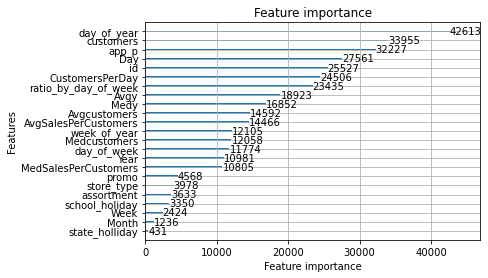

In [259]:
lgb.plot_importance(base_lgb_model)

In [260]:
features = build_features(test_df, store_df)

test_preds = base_lgb_model.predict(features[X])

test_preds

<ipython-input-241-7fb8fb43d66a>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week


array([ -29.89203903,   40.29338333,  -38.96683344, ..., 7251.35414882,
       4978.1247668 , 7246.28861982])

### Bagging

In [268]:
regr = BaggingRegressor(base_estimator=base_lgb_model,
                       n_estimators=50, verbose = 1)

regr.fit(X1, y1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3231
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5776.636978
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3231
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5771.088640
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3230
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3232
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5766.045907
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3231
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5770.386181
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3231
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3232
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5778.742044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3233
[LightGBM] [Info] Number of data points in the train set: 813767, number of used features: 23
[LightGBM] [Info] Start training from score 5770.218073


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 124.9min finished


BaggingRegressor(base_estimator=LGBMRegressor(colsample_bytree=0.8,
                                              learning_rate=0.12, max_depth=15,
                                              min_child_weight=0.008,
                                              n_estimators=4900, num_leaves=65,
                                              reg_alpha=0.1, reg_lambda=1,
                                              subsample=0.8, verbose=1),
                 n_estimators=50, verbose=1)

In [269]:
features = build_features(test_df, store_df)

test_preds = regr.predict(features[X])

test_preds

<ipython-input-241-7fb8fb43d66a>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  merged['Week'] = pd.to_datetime(merged['date']).dt.week
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 38.7min finished


array([ -21.7132843 ,   24.48782299,   22.4575506 , ..., 7120.22870684,
       4954.99075502, 7157.6003615 ])

## Stacking Models

In [ ]:
level0 = list()
level0.append(('xgboost', XGBRegressor(
    n_estimators = 140,
    eta = 0.1,
    max_depth = 17,
    min_child_weight = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.06,
    random_state = 1043)))
level0.append(('RandomForest', RandomForestRegressor()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X1, y1)

In [ ]:
features = build_features(test_df, store_df)

test_preds = model.predict(features[X])

test_preds

## Error Observation

In [ ]:
y_pred = base_lgb_model.predict(X1)
X2 = X1
X2['abs_error'] = np.abs(y1-y_pred)
X2['y'], X2['y_pred'] = y1 , y_pred
X2 = X2.sort_values(by=['abs_error'], ascending=False)
#X2

In [ ]:
X2['ratio_actual'] = X2['y'] / X2['customers']

In [ ]:
X2.head(60)

In [ ]:
X2['abs_error'].describe()
#X2.boxplot(column='abs_error')

## Save as .csv

In [272]:
d = {'y': test_preds}
result = pd.DataFrame(data=d)
result.index.names = ['index']
result = result['y'].apply(lambda x: 0 if x<200 else x)
result

index
0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
             ...     
203437    7067.506574
203438    9492.536354
203439    7120.228707
203440    4954.990755
203441    7157.600362
Name: y, Length: 203442, dtype: float64

In [273]:
result.to_csv('solution.csv',encoding='ISO-8859-1', sep=',')